<a href="https://colab.research.google.com/github/lochieh19798/Data-analysis/blob/main/Figure2mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edition control

In [1]:
!git config --global user.name "lochieh19798"
!git config --global user.email "lochieh19798@gmail.com"

In [2]:
!git clone https://github.com/lochieh19798/data-analysis

Cloning into 'data-analysis'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 124 (delta 61), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 15.02 MiB | 9.41 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [3]:
# ╔═╡ Cell 0 ═════════════════════════════════════════════════════════════╗
# If you’re on Colab, install any non-preinstalled libraries:
!pip install -q catboost shap scikit-learn==1.4.2 matplotlib pandas numpy
!pip install -q --upgrade xgboost
!pip install -q shap --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.8 MB/s eta 0:00:00


In [4]:
from xgboost.sklearn import XGBModel
XGBModel.feature_weights = None
print("Patched XGBModel.feature_weights →", XGBModel.feature_weights)

Patched XGBModel.feature_weights → None


In [5]:
# ╔═╡ Cell 1 ═════════════════════════════════════════════════════════════╗
# Imports & global configuration
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.impute import (
    KNNImputer,
    SimpleImputer
    # ← no IterativeImputer here
)
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    ExtraTreesClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 43
plt.style.use("default")


In [6]:
# ╔═╡ Cell 2 – load data & build feature lists with missing‐% report ═════╝
from pathlib import Path
import pandas as pd

# 1. Data‐loading helper (as before)
DATA_PATH = "/content/data-analysis/CRYOANALYSIS.csv"
def load_and_prepare_data(csv_path: str = DATA_PATH) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # (1) Recurrence flags
    df["Survival_time"] = pd.to_numeric(df["Survival_time"], errors="coerce")
    df = df.dropna(subset=["Survival_time", "Recurrence"])
    df["Recurrence_1yr"] = ((df["Survival_time"] <= 365) & (df["Recurrence"] == 1)).astype(int)
    df["Recurrence_2yr"] = ((df["Survival_time"] <= 730) & (df["Recurrence"] == 1)).astype(int)
    # (2) AF type one‐hot
    af_col = "Baseline AF Type(1=paroxysmal, 2=persistent)"
    df["AF_Parox"]   = (df[af_col] == 1).astype(int)
    df["AF_Persist"] = (df[af_col] == 2).astype(int)
    return df

# 2. Load the dataset
DATA_PATH = Path("/content/data-analysis/CRYOANALYSIS.csv")
assert DATA_PATH.exists(), f"{DATA_PATH} not found – upload it first!"
df = load_and_prepare_data(DATA_PATH)

# 3. Feature lists
cont = [
    "age", "BMI",
    "Baseline LVEF", "Baseline LAD", "CHA2DS2VASc score", "CHAD2 score", "AF_time_procedure",
    "Total no of ablation application number",
    # "Self-care question (Baseline)", "Usual activities question (Baseline)", "Mobility question (Baseline)",
    # "Pain/Discomfort question (Baseline)", "Anxiety/Depression question (Baseline)",
    "Visual analogue score: Your own health state today (Baseline)",
    "Total procedure time: Venous access to last cryoatheter removal (mins)",
    "Total fluoro time (mins)", "Energy duration LSPV", "Coldest Temperature LSPV",
    "Energy duration LIPV", "Coldest Temperature LIPV",
    "Energy duration RSPV", "Coldest temperature RSPV",
    "Energy duration RIPV", "Coldest Temperature RIPV",
    "Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins)",
    # "Change in EQ 5D"
    # "Time to isolation LSPV", "Time to isolation LIPV", "Time to isolation RSPV","Time to isolation RIPV",
]

cat = [
    "Sex (F=1, M=0)", "Hypertension", "Diabetes", "HF", "CAD", "stroke",
    "History of TIA", "Subject taking Class I or III AAD at baseline (1=Yes, 0=No)",
    "LSPV isolated", "LIPV PV isolated", "RSPV Isolated", "RIPV isolated",
    "Were all targeted PVs isolated (Investigator)?",
    "AF_Parox", "AF_Persist",
    "CTI ablation",
    "Non-PVI ablation performed",
    "Was subject taking Class I or Class III AAD at procedure discharge?",
    "Mapping/navigational tools: Intracardiac echocardiography (ICE)",
    "Pre Procedural CT",
    "Ensite 3D mapping"
]

TARGET = "Recurrence_2yr"

# 4. Report missing‐value percentages for every feature
all_feats = cont + cat
missing_pct = df[all_feats].isna().mean() * 100
missing_report = (
    missing_pct
      .sort_values(ascending=False)
      .rename("missing_pct")
      .reset_index()
      .rename(columns={"index": "variable"})
)
print("📊 Missing Value Percentage per Feature:")
print(missing_report.to_string(index=False, float_format="%.1f%%"))

# 5. Gentle column check: warn & drop if still missing
missing_cont = [c for c in cont if c not in df.columns]
missing_cat  = [c for c in cat  if c not in df.columns]
if missing_cont or missing_cat:
    print("\n⚠️  WARNING – some expected columns are missing and will be skipped.")
    print("   Missing continuous :", missing_cont)
    print("   Missing categorical:", missing_cat)

cont = [c for c in cont if c in df.columns]
cat  = [c for c in cat  if c in df.columns]

# From here on, the rest of the notebook runs as before...


📊 Missing Value Percentage per Feature:
                                                                                          variable  missing_pct
                                                                                      Baseline LAD        32.7%
                                     Visual analogue score: Your own health state today (Baseline)        25.6%
                                                                          Coldest Temperature LIPV        25.3%
                                                                          Coldest Temperature LSPV        23.8%
                                                                                     Baseline LVEF        23.8%
                                                                          Coldest Temperature RIPV        23.8%
                                                                          Coldest temperature RSPV        23.8%
                                                                

In [7]:
# ╔═╡ Cell 3 – Train vs. Hold-out Split for k-Fold CV ─────────────────────╗
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) (Optional) Sort by date to preserve temporal order
df["ProcedureDate"] = pd.to_datetime(df["ProcedureDate"])
df_sorted = df.sort_values("ProcedureDate")

# 2) Extract feature matrix & target vector
X_all = df_sorted[cont + cat]
y_all = df_sorted[TARGET].astype(int)

# 3) Single stratified split: 80% train, 20% hold-out
X_train, X_hold, y_train, y_hold = train_test_split(
    X_all,
    y_all,
    test_size=0.30,
    stratify=y_all,
    random_state=RANDOM_STATE
)

# 4) Report counts and event rates
print("Split sizes:")
print(f"  • Train:    {len(y_train)} samples")
print(f"  • Hold-out: {len(y_hold)} samples")
print(f"  • Total:    {len(y_train) + len(y_hold)} samples\n")

print("Event rates:")
print(f"  • Overall:    {y_all.mean():.2%}")
print(f"  • Train:      {y_train.mean():.2%}")
print(f"  • Hold-out:   {y_hold.mean():.2%}")


Split sizes:
  • Train:    196 samples
  • Hold-out: 85 samples
  • Total:    281 samples

Event rates:
  • Overall:    19.22%
  • Train:      19.39%
  • Hold-out:   18.82%


In [8]:
# ╔═╡ Cell 4 – Pre-processing pipelines ═══════════════════════════════════╗
# (Make sure to enable the experimental IterativeImputer)
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline           import Pipeline
from sklearn.impute             import IterativeImputer, SimpleImputer
from sklearn.preprocessing      import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose            import ColumnTransformer

# Numeric pipeline: iterative imputation → power transform → scaling
numeric_pipe = Pipeline([
    ("impute", IterativeImputer(random_state=RANDOM_STATE)),
    ("power",  PowerTransformer(method="yeo-johnson")),
    ("scale",  StandardScaler())
])

# Categorical pipeline: fill missing with "Missing" → one-hot encode
categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Full preprocessor: apply to continuous and categorical lists
preprocessor = ColumnTransformer([
    ("num", numeric_pipe,       cont),
    ("cat", categorical_pipe,   cat)
], remainder="drop")


In [9]:
# ╔═╡ Cell 4b – preview IterativeImputer + PowerTransformer on numeric features ═══════╗
import warnings
from sklearn.exceptions import ConvergenceWarning

# (Optionally suppress FutureWarnings or ConvergenceWarnings)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 1. Show missing counts before
num_train = X_train[cont].copy()
print("🔴 Missing before imputation (numeric features):")
print(num_train.isna().sum())

# 2. Fit & transform with your updated numeric_pipe
num_imputed = pd.DataFrame(
    numeric_pipe.fit_transform(num_train),
    columns=cont,
    index=num_train.index
)

# 3. Show missing counts after
print("\n🟢 Missing after IterativeImputer + PowerTransformer:")
print(num_imputed.isna().sum())

# 4. Display first few rows of the transformed DataFrame
display(num_imputed.head())


🔴 Missing before imputation (numeric features):
age                                                                                                    0
BMI                                                                                                    0
Baseline LVEF                                                                                         43
Baseline LAD                                                                                          60
CHA2DS2VASc score                                                                                      0
CHAD2 score                                                                                            0
AF_time_procedure                                                                                     18
Total no of ablation application number                                                                0
Visual analogue score: Your own health state today (Baseline)                                         53
Total p

,age,BMI,Baseline LVEF,Baseline LAD,CHA2DS2VASc score,CHAD2 score,AF_time_procedure,Total no of ablation application number,Visual analogue score: Your own health state today (Baseline),Total procedure time: Venous access to last cryoatheter removal (mins),Total fluoro time (mins),Energy duration LSPV,Coldest Temperature LSPV,Energy duration LIPV,Coldest Temperature LIPV,Energy duration RSPV,Coldest temperature RSPV,Energy duration RIPV,Coldest Temperature RIPV,Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins)
53,-0.143642,-0.722661,0.268118,-0.762626,2.045987,1.826317,-0.371526,-3.197429,0.081074,0.080643,0.041397,0.283419,0.138680,0.099236,0.125348,0.046926,0.030861,0.088895,-0.070788,0.189216
261,-0.231222,-0.258819,-0.181191,-0.155750,-0.546494,-1.141146,0.130229,-0.567480,-0.790563,-0.606047,2.425395,-0.089278,1.481270,0.149803,-2.059543,-1.157988,1.043920,-1.376761,0.696514,0.768389
171,1.506021,0.424727,-1.295440,0.258462,0.823180,1.060053,0.658470,-1.022603,0.422861,-1.483070,-1.105378,-0.089278,0.912999,0.149803,0.643939,-1.157988,0.660022,-1.376761,-1.006157,-0.778066
43,0.831766,0.647479,1.065119,-0.762626,-1.771674,-1.141146,0.764486,0.397831,-0.281206,1.648088,1.051175,1.167634,-0.062984,0.149803,-0.560986,0.242253,0.122082,0.100456,-0.581611,-1.528026
95,0.519909,-0.378178,-1.510298,-0.083671,0.236124,0.345238,-0.549335,-0.093520,-0.002218,-0.137123,-0.458160,-0.089278,0.713642,0.149803,-0.470227,-0.034119,-1.276933,0.100456,-1.430239,0.706060


In [10]:
# ╔═╡ Cell 4c – preview string-cast → impute → one-hot on categorical features ═══════╗
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import FunctionTransformer, OneHotEncoder
from sklearn.impute            import SimpleImputer
import pandas as pd

# 1) Re-define categorical_pipe to cast → impute → one-hot
categorical_pipe = Pipeline([
    # cast every value to string
    ("to_str",   FunctionTransformer(lambda X: X.astype(str), validate=False)),
    # fill missing with literal "Missing"
    ("impute",   SimpleImputer(strategy="constant", fill_value="Missing")),
    # one-hot encode the strings
    ("onehot",   OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# 2. Grab the raw cat columns (with NaNs)
cat_train = X_train[cat].copy()
print("🔴 Missing before imputation (categorical features):")
print(cat_train.isna().sum())

# 3. Fit & transform via the updated pipeline
cat_ohe_array = categorical_pipe.fit_transform(cat_train)

# 4. Turn back into a DataFrame
cat_ohe_cols = categorical_pipe.named_steps["onehot"].get_feature_names_out(cat)
cat_imputed  = pd.DataFrame(cat_ohe_array, columns=cat_ohe_cols, index=cat_train.index)

print("\n🟢 Missing after to_str → SimpleImputer → OneHotEncoder:")
print(cat_imputed.isna().sum().sum(), "total NaNs remaining")

print("\n🖨️ Sample of the imputed one-hot matrix:")
display(cat_imputed.iloc[:, :10].head())


🔴 Missing before imputation (categorical features):
Sex (F=1, M=0)                                                         0
Hypertension                                                           0
Diabetes                                                               0
HF                                                                     0
CAD                                                                    0
stroke                                                                 0
History of TIA                                                         0
Subject taking Class I or III AAD at baseline (1=Yes, 0=No)            8
LSPV isolated                                                          0
LIPV PV isolated                                                       1
RSPV Isolated                                                          1
RIPV isolated                                                          2
Were all targeted PVs isolated (Investigator)?                         7

,"Sex (F=1, M=0)_0","Sex (F=1, M=0)_1",Hypertension_0,Hypertension_1,Diabetes_0,Diabetes_1,HF_0,HF_1,CAD_0,CAD_1
53,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
261,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
171,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
43,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
95,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [11]:
# ╔═╡ Cell 4d – inspect full preprocessed feature space ─══════════════╗
from sklearn.compose import ColumnTransformer

# 1) Re‐build the ColumnTransformer as in Cell 4
ct = ColumnTransformer([
    ("num", numeric_pipe, cont),
    ("cat", categorical_pipe, cat)
], remainder="drop")

# 2) Fit & transform your training set
X_tr_full = ct.fit_transform(X_train)

# 3) Manually assemble the feature names:
#    - numeric features keep their original names
num_features = cont

#    - categorical features come from the OneHotEncoder inside categorical_pipe
cat_ohe_names = categorical_pipe.named_steps["onehot"] \
                     .get_feature_names_out(cat)

#    - combine
feat_names = list(num_features) + list(cat_ohe_names)

# 4) Report
print(f"➡️  Combined train matrix: {X_tr_full.shape[0]} rows × {X_tr_full.shape[1]} cols")
print(f"📦  Total features = {len(feat_names)}")
print("🔍  Example feature names:", feat_names[:10], "…", feat_names[-10:])

# 5) (optional) display the first few rows in a DataFrame
import pandas as pd
df_feats = pd.DataFrame(X_tr_full, columns=feat_names, index=X_train.index)
df_feats.head()


➡️  Combined train matrix: 196 rows × 69 cols
📦  Total features = 69
🔍  Example feature names: ['age', 'BMI', 'Baseline LVEF', 'Baseline LAD', 'CHA2DS2VASc score', 'CHAD2 score', 'AF_time_procedure', 'Total no of ablation application number', 'Visual analogue score: Your own health state today (Baseline)', 'Total procedure time: Venous access to last cryoatheter removal (mins)'] … ['Was subject taking Class I or Class III AAD at procedure discharge?_0', 'Was subject taking Class I or Class III AAD at procedure discharge?_1', 'Mapping/navigational tools: Intracardiac echocardiography (ICE)_0', 'Mapping/navigational tools: Intracardiac echocardiography (ICE)_1', 'Pre Procedural CT_0.0', 'Pre Procedural CT_1.0', 'Pre Procedural CT_nan', 'Ensite 3D mapping_0.0', 'Ensite 3D mapping_1.0', 'Ensite 3D mapping_nan']


,age,BMI,Baseline LVEF,Baseline LAD,CHA2DS2VASc score,CHAD2 score,AF_time_procedure,Total no of ablation application number,Visual analogue score: Your own health state today (Baseline),Total procedure time: Venous access to last cryoatheter removal (mins),...,Was subject taking Class I or Class III AAD at procedure discharge?_0,Was subject taking Class I or Class III AAD at procedure discharge?_1,Mapping/navigational tools: Intracardiac echocardiography (ICE)_0,Mapping/navigational tools: Intracardiac echocardiography (ICE)_1,Pre Procedural CT_0.0,Pre Procedural CT_1.0,Pre Procedural CT_nan,Ensite 3D mapping_0.0,Ensite 3D mapping_1.0,Ensite 3D mapping_nan
53,-0.143642,-0.722661,0.268118,-0.762626,2.045987,1.826317,-0.371526,-3.197429,0.081074,0.080643,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
261,-0.231222,-0.258819,-0.181191,-0.155750,-0.546494,-1.141146,0.130229,-0.567480,-0.790563,-0.606047,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
171,1.506021,0.424727,-1.295440,0.258462,0.823180,1.060053,0.658470,-1.022603,0.422861,-1.483070,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
43,0.831766,0.647479,1.065119,-0.762626,-1.771674,-1.141146,0.764486,0.397831,-0.281206,1.648088,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
95,0.519909,-0.378178,-1.510298,-0.083671,0.236124,0.345238,-0.549335,-0.093520,-0.002218,-0.137123,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [12]:
# ------------- 4.3 Define candidate models ------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, cont),
        ("cat", categorical_pipe, cat)
    ],
    remainder="drop"   # or "passthrough" if you have other cols
)

In [13]:
# ╔═╡ Cell 4.4 – helper for CatBoost (just fill categoricals) ═════════════╗
def prepare_for_catboost(
    X: pd.DataFrame,
    cat_cols: list[str]
) -> pd.DataFrame:
    """
    Copy X, replace any NaN in the specified categorical columns
    with a literal 'Missing' string (so CatBoost sees it as a valid category).
    Leave all other columns untouched (CatBoost will handle numeric NaNs if any).
    """
    X_cb = X.copy()
    for c in cat_cols:
        X_cb[c] = X_cb[c].fillna("Missing").astype(str)
    return X_cb


In [14]:
# ╔═╡ Cell 4.6 – Faster tune of ExtraTrees via RandomizedSearchCV with SMOTE ═╗
from imblearn.pipeline      import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble       import ExtraTreesClassifier
import numpy as np

# 1) Pipeline: impute/encode → SMOTE → ExtraTrees
et_pipe = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", ExtraTreesClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1          # speed up individual fits
    ))
])

# 2) Narrower/random search space
param_dist = {
    "clf__n_estimators":     [100, 300, 500, 800],
    "clf__max_depth":        [None, 10, 20],
    "clf__max_features":     ["sqrt", "log2"],
    "clf__min_samples_split":[2, 5],
    "clf__min_samples_leaf": [1, 2]
}

# 3) RandomizedSearchCV – just 30 draws instead of 720 fits
et_rand = RandomizedSearchCV(
    et_pipe,
    param_distributions=param_dist,
    n_iter=30,             # only 30 random combinations
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 4) Fit
et_rand.fit(X_train, y_train)

print("✅ Best ExtraTrees params:", et_rand.best_params_)
print("✅ Best CV AUC:         ", et_rand.best_score_)

# 5) Save the params
best_et_params = {
    "n_estimators":     et_rand.best_params_["clf__n_estimators"],
    "max_depth":        et_rand.best_params_["clf__max_depth"],
    "max_features":     et_rand.best_params_["clf__max_features"],
    "min_samples_split":et_rand.best_params_["clf__min_samples_split"],
    "min_samples_leaf": et_rand.best_params_["clf__min_samples_leaf"]
}

best_et_n      = best_et_params["n_estimators"]
best_et_depth  = best_et_params["max_depth"]
best_et_feats  = best_et_params["max_features"]
best_et_split  = best_et_params["min_samples_split"]
best_et_leaf   = best_et_params["min_samples_leaf"]

Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Best ExtraTrees params: {'clf__n_estimators': 300, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': 20}
✅ Best CV AUC:          0.7061707949308754


In [15]:
# ╔═╡ Cell 4.8 – Randomized tune for HistGB with SMOTE (enable splits) ═════╗
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling  import SMOTE
from sklearn.ensemble        import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

# 1) Pipeline: preprocess → SMOTE → HistGB (early stopping on SMOTE’d data)
hgb_pipe = ImbPipeline([
    ("prep",   preprocessor),
    ("smote",  SMOTE(random_state=RANDOM_STATE)),
    ("clf",    HistGradientBoostingClassifier(
                   loss="log_loss",
                   early_stopping="auto",
                   validation_fraction=0.1,
                   n_iter_no_change=10,    # stop after 10 rounds without improvement
                   random_state=RANDOM_STATE
               ))
])

# 2) A richer, more permissive grid
param_dist = {
    "clf__learning_rate":     [0.01, 0.03, 0.1],
    "clf__max_iter":          [200, 500, 1000],
    "clf__max_depth":         [3, 5, None],
    "clf__min_samples_leaf":  [1, 5, 10, 20],      # now including small leaves
    "clf__l2_regularization": [0.0, 0.1, 1.0],
    "clf__max_leaf_nodes":    [15, 31, 63]
}

# 3) More stable CV: 5 folds × 2 repeats
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

# 4) RandomizedSearchCV
hgb_rand = RandomizedSearchCV(
    hgb_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=rskf,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 5) Fit and capture best params
hgb_rand.fit(X_train, y_train)
best_hgb_params = {k.replace("clf__", ""): v for k, v in hgb_rand.best_params_.items()}
print("✅ Best HistGB params:", best_hgb_params,
      "→ CV AUC:", hgb_rand.best_score_)


Fitting 10 folds for each of 30 candidates, totalling 300 fits
✅ Best HistGB params: {'min_samples_leaf': 20, 'max_leaf_nodes': 15, 'max_iter': 500, 'max_depth': None, 'learning_rate': 0.01, 'l2_regularization': 1.0} → CV AUC: 0.6982772897465438


In [16]:
# ╔═╡ Cell 5 – Build models dict with SMOTE in every pipeline ─════════╗
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

models = {
    "LogReg": RandomizedSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   LogisticRegression(
                          solver="saga",
                          penalty="elasticnet",
                          l1_ratio=0.5,
                          class_weight="balanced",
                          max_iter=5000,
                          random_state=RANDOM_STATE
                      ))
        ]),
        param_distributions={
            "clf__C":        [1e-3, 1e-2, 1e-1, 1, 10, 100],
            "clf__l1_ratio":[0.0, 0.25, 0.5, 0.75, 1.0]
        },
        n_iter=20,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),

    "SVM": RandomizedSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   SVC(
                          probability=True,
                          kernel="rbf",
                          class_weight="balanced",
                          random_state=RANDOM_STATE
                      ))
        ]),
        param_distributions={
            "clf__C":     np.logspace(-3, 3, 20),
            "clf__gamma": np.logspace(-4, 0, 20)
        },
        n_iter=30,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),

    "NaiveBayes": GridSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   GaussianNB())
        ]),
        param_grid={"clf__var_smoothing": np.logspace(-12, -6, 6)},
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        refit=True
    ),

    "ExtraTrees": ImbPipeline([
        ("prep",  preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf",   ExtraTreesClassifier(
                      n_estimators=     best_et_n,
                      max_depth=        best_et_depth,
                      max_features=     best_et_feats,
                      min_samples_split=best_et_split,
                      min_samples_leaf= best_et_leaf,
                      random_state=     RANDOM_STATE,
                      class_weight=     "balanced",
                      n_jobs=-1
                  ))
    ]),

    "HistGB": ImbPipeline([
        ("prep",   preprocessor),
        ("smote",  SMOTE(random_state=RANDOM_STATE)),
        ("clf",    HistGradientBoostingClassifier(
                       loss="log_loss",
                       learning_rate=     best_hgb_params["learning_rate"],
                       max_iter=          best_hgb_params["max_iter"],
                       max_depth=         best_hgb_params["max_depth"],
                       min_samples_leaf=  1,                          # allow tiny leaves
                       l2_regularization= best_hgb_params["l2_regularization"],
                       max_leaf_nodes=    best_hgb_params["max_leaf_nodes"],
                       early_stopping="auto",                         # re-enable
                       n_iter_no_change= 10,                          # patience on SMOTE data
                       validation_fraction=0.1,                       # internal hold-out
                       random_state=      RANDOM_STATE
                   ))
    ])
}

# If you still need the cat_features_idx for SHAP or CatBoost elsewhere:
cat_features_idx = [X_train.columns.get_loc(c) for c in cat]


In [17]:
# ╔═╡ Cell 5.1 – Full-train smoke test on hold-out ═════════════════════╗
from sklearn.metrics import roc_auc_score

print("=== Pipeline structure ===")
for name, pipe in models.items():
    print(f"{name}:")
    if hasattr(pipe, "steps"):
        print("  Steps:", [step for step, _ in pipe.steps])
    else:
        print("  (not a pipeline!)", type(pipe).__name__)
    print()

print("=== Smoke test (fit on full X_train, score on X_hold) ===")
for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)
        probs = pipe.predict_proba(X_hold)[:, 1]
        auc   = roc_auc_score(y_hold, probs)
        print(f"{name}: ✔ fitted & predict_proba OK → AUC on hold-out = {auc:.3f}")
    except Exception as e:
        print(f"{name}: ✖ ERROR → {e}")


=== Pipeline structure ===
LogReg:
  (not a pipeline!) RandomizedSearchCV

SVM:
  (not a pipeline!) RandomizedSearchCV

NaiveBayes:
  (not a pipeline!) GridSearchCV

ExtraTrees:
  Steps: ['prep', 'smote', 'clf']

HistGB:
  Steps: ['prep', 'smote', 'clf']

=== Smoke test (fit on full X_train, score on X_hold) ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
LogReg: ✔ fitted & predict_proba OK → AUC on hold-out = 0.501
Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM: ✔ fitted & predict_proba OK → AUC on hold-out = 0.527
Fitting 5 folds for each of 6 candidates, totalling 30 fits
NaiveBayes: ✔ fitted & predict_proba OK → AUC on hold-out = 0.563
ExtraTrees: ✔ fitted & predict_proba OK → AUC on hold-out = 0.467
HistGB: ✔ fitted & predict_proba OK → AUC on hold-out = 0.522


In [18]:
# ╔═╡ Cell 5.2 – Faster CatBoost tuning via smaller grid, lighter CV, early-stop ═══╗
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
import numpy as np
import os
from contextlib import redirect_stdout


# 1) Prep data (as before)
X_train_cb = prepare_for_catboost(X_train, cat)

# 2) GPU CatBoost + Iter-based early stopping, silencing logs
cb = CatBoostClassifier(
    task_type="CPU",            # run on CPU (no GPU overhead)
    bootstrap_type="Bernoulli", # enable subsample regularization
    subsample=0.8,              # use 80% of rows per tree
    od_type="Iter",             # overfitting detector
    od_wait=20,                 # stop if no Logloss improvement in 20 its
    loss_function="Logloss",    # training objective
    eval_metric="Logloss",      # monitor Logloss for early stopping
    metric_period=1,            # compute Logloss every iteration
    logging_level="Silent",     # suppress CatBoost INFO/WARN
    random_seed=RANDOM_STATE
)

# 3) Narrowed hyper-space
param_dist = {
    "iterations":        [200, 500, 1000],
    "depth":             [4, 6, 8],
    "learning_rate":     [0.01, 0.03, 0.05, 0.1],
    "l2_leaf_reg":       [1, 3, 5],
    "subsample":         [0.6, 0.8, 1.0],
    "border_count":      [32, 64, 128],
    "random_strength":   [0.0, 0.5, 1.0],
    "leaf_estimation_iterations": [1, 3, 5]
}

# 4) CV: 5-fold single repeat
rskf = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=2,
    random_state=RANDOM_STATE
)

# 5) Fewer trials & no GPU contention
rs_cb = RandomizedSearchCV(
    cb,
    param_distributions=param_dist,
    n_iter=5,          # just 5 random combos
    scoring="roc_auc",
    cv=rskf,
    n_jobs=1,          # one process → one GPU job at a time
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 6) Fit quietly by redirecting CatBoost’s GPU‐AUC notices to null
with open(os.devnull, "w") as fnull:
    with redirect_stdout(fnull):
        rs_cb.fit(
            X_train_cb,
            y_train,
            cat_features=cat_features_idx
        )

print("✅ Best params:", rs_cb.best_params_)
print("✅ Best CV AUC:", rs_cb.best_score_)

# 7) Save & recompute
models["CatBoost"]     = rs_cb.best_estimator_
cat_features_idx = [X_train.columns.get_loc(c) for c in cat]


✅ Best params: {'subsample': 0.6, 'random_strength': 0.5, 'learning_rate': 0.01, 'leaf_estimation_iterations': 5, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8, 'border_count': 128}
✅ Best CV AUC: 0.7699542770737328


In [19]:
# ╔═╡ Cell 5.3 – Deep hyper-tuning AdaBoost with SMOTE & repeated stratified CV ══╗
from imblearn.pipeline            import Pipeline as ImbPipeline
from imblearn.over_sampling       import SMOTE
from sklearn.tree                 import DecisionTreeClassifier
from sklearn.ensemble             import AdaBoostClassifier
from sklearn.model_selection      import RandomizedSearchCV, RepeatedStratifiedKFold
import numpy as np

# 1) Pipeline: preprocess → SMOTE → AdaBoost(with explicit base tree)
ab_pipe = ImbPipeline([
    ("prep",  preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf",   AdaBoostClassifier(
                  estimator=DecisionTreeClassifier(
                      random_state=RANDOM_STATE
                  ),
                  random_state=RANDOM_STATE
              ))
])

# 2) A richer Randomized grid
param_dist = {
    "clf__n_estimators":                [50, 100, 200, 400, 800],
    "clf__learning_rate":               [0.01, 0.05, 0.1, 0.5, 1.0],
    "clf__algorithm":                   ["SAMME", "SAMME.R"],
    "clf__estimator__max_depth":        [1, 2, 3, 4, None],
    "clf__estimator__min_samples_split":[2, 5, 10],
    "clf__estimator__min_samples_leaf": [1, 2, 4]
}

# 3) Repeated stratified K-fold
rskf = RepeatedStratifiedKFold(
    n_splits=3,
    n_repeats=3,
    random_state=RANDOM_STATE
)

# 4) RandomizedSearchCV
ab_search = RandomizedSearchCV(
    ab_pipe,
    param_distributions=param_dist,
    n_iter=30,                # 50 random draws
    scoring="roc_auc",
    cv=rskf,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    refit=True
)

# 5) Fit on your build set
ab_search.fit(X_train, y_train)

print("✅ Best AdaBoost params:", ab_search.best_params_)
print("✅ Best CV AUC:        ", ab_search.best_score_)

# 6) Store the tuned pipeline
models["AdaBoost"] = ab_search.best_estimator_


Fitting 9 folds for each of 30 candidates, totalling 270 fits
✅ Best AdaBoost params: {'clf__n_estimators': 200, 'clf__learning_rate': 1.0, 'clf__estimator__min_samples_split': 2, 'clf__estimator__min_samples_leaf': 4, 'clf__estimator__max_depth': None, 'clf__algorithm': 'SAMME'}
✅ Best CV AUC:         0.6973782144319154


In [20]:
# ╔═╡ Cell 5.4 – Enhanced Randomized search → final XGBoost (CPU) ═════════════╗
import xgboost as xgb
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import OrdinalEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
import numpy as np

# 1) Simple preprocessor
num_imp = SimpleImputer(strategy="median")
cat_imp_enc = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value=-1)),
    ("encode", OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])
pre_xgb = ColumnTransformer([
    ("num", num_imp, cont),
    ("cat", cat_imp_enc, cat)
], remainder="drop")

# 2) Base pipeline using CPU for training
xgb_pipe = Pipeline([
    ("pre", pre_xgb),
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",    # histogram method on CPU
        n_jobs=-1,             # use all CPU cores
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        random_state=RANDOM_STATE
    ))
])

# 3) Expanded random search space
param_dist = {
    "clf__n_estimators":     [100, 300, 600, 1000],
    "clf__max_depth":        [3, 5, 7, 9],
    "clf__learning_rate":    [0.001, 0.01, 0.03, 0.1],
    "clf__subsample":        [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma":            [0, 1, 5],
    "clf__reg_alpha":        [0, 0.1, 1],
    "clf__reg_lambda":       [1, 5, 10]
}

# 4) Repeated stratified CV & randomized search
rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
rs_xgb = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=rsk,
    n_jobs=1,
    verbose=0,             # ← no CV logs
    random_state=RANDOM_STATE,
    refit=True
)

# 5) Run the search
rs_xgb.fit(X_train, y_train)

print("✅ Best XGB params:", rs_xgb.best_params_)
print("✅ Best CV AUC:   ", rs_xgb.best_score_)

# 6) Build final XGB with early stopping on CPU
best_params = {k.replace("clf__", ""): v for k, v in rs_xgb.best_params_.items()}
xgb_final = xgb.XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    n_jobs=-1,                    # CPU parallelism
    early_stopping_rounds=30,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=RANDOM_STATE
)

# 7) Fit preprocessor & transform train + hold-out
pre_xgb.fit(X_train)
X_tr = pre_xgb.transform(X_train)
X_te = pre_xgb.transform(X_hold)                # ← use hold-out here

# 8) Train final model with early stopping
xgb_final.fit(
    X_tr,
    y_train,
    eval_set=[(X_te, y_hold)],
    verbose=False
)

# 9) Save the pipeline for downstream use
models["XGBoost"] = Pipeline([("pre", pre_xgb), ("clf", xgb_final)])


✅ Best XGB params: {'clf__subsample': 0.6, 'clf__reg_lambda': 5, 'clf__reg_alpha': 0, 'clf__n_estimators': 300, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__gamma': 5, 'clf__colsample_bytree': 1.0}
✅ Best CV AUC:    0.7289710541474654


In [21]:
# ╔═╡ Cell 6 – Stratified 5-fold ROC (mean ± std) with SMOTE, scaling & calibration ═════╗
import numpy as np
from sklearn.model_selection      import StratifiedKFold
from sklearn.metrics              import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.base                 import clone
from sklearn.preprocessing        import StandardScaler
from sklearn.calibration          import CalibratedClassifierCV
from imblearn.over_sampling       import SMOTE
from imblearn.pipeline            import Pipeline as ImbPipeline
from sklearn.pipeline             import Pipeline as SkPipeline
from sklearn.ensemble             import VotingClassifier

# 1) Rebuild “full” pipelines, inserting a scaler before SVM
full_pipes = {}
for name, mdl in models.items():
    pipe = mdl.best_estimator_ if hasattr(mdl, "best_estimator_") else mdl

    if name == "SVM":
        # add scaling for SVM
        pipe = ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("scale", StandardScaler()),
            ("clf",   pipe.named_steps["clf"])
        ])

    if isinstance(pipe, (SkPipeline, ImbPipeline)):
        full_pipes[name] = pipe
    else:
        steps = [("prep", preprocessor)]
        if name != "CatBoost":
            steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
        steps.append(("clf", pipe))
        full_pipes[name] = ImbPipeline(steps) if name != "CatBoost" else SkPipeline(steps)

# 2) 5-fold stratified CV
skf      = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
mean_fpr = np.linspace(0, 1, 200)
aucs     = {n: [] for n in full_pipes}
mean_tpr = {n: np.zeros_like(mean_fpr) for n in full_pipes}

# 3) Loop folds
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    print(f"\n--- Fold {fold} ---")

    for name, pipe in full_pipes.items():
        # clone and disable early stopping for inner calibration if needed
        base = clone(pipe)
        if name == "XGBoost" and hasattr(base, "set_params"):
            base.set_params(**{"clf__early_stopping_rounds": None})
        if name == "HistGB" and hasattr(base, "set_params"):
            base.set_params(**{"clf__early_stopping": False})

        # calibrate to improve probability estimates
        calibrator = CalibratedClassifierCV(base, method="sigmoid", cv=3)
        calibrator.fit(X_tr, y_tr)

        # predict & score
        y_prob      = calibrator.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        auc_score   = roc_auc_score(y_val, y_prob)
        aucs[name].append(auc_score)
        mean_tpr[name] += np.interp(mean_fpr, fpr, tpr)

        print(f"{name:12s} AUC = {auc_score:.3f}")

# 4) Report per-fold summary
print("\n=== Summary of per‐fold AUCs ===")
for name, scores in aucs.items():
    m, s = np.mean(scores), np.std(scores)
    print(f"{name:12s}: {[f'{x:.3f}' for x in scores]} → {m:.3f}±{s:.3f}")


--- Fold 1 ---
LogReg       AUC = 0.645
SVM          AUC = 0.590
NaiveBayes   AUC = 0.613
ExtraTrees   AUC = 0.562
HistGB       AUC = 0.574
CatBoost     AUC = 0.629
AdaBoost     AUC = 0.664
XGBoost      AUC = 0.621

--- Fold 2 ---
LogReg       AUC = 0.750
SVM          AUC = 0.656
NaiveBayes   AUC = 0.471
ExtraTrees   AUC = 0.603
HistGB       AUC = 0.732
CatBoost     AUC = 0.643
AdaBoost     AUC = 0.688
XGBoost      AUC = 0.701

--- Fold 3 ---
LogReg       AUC = 0.670
SVM          AUC = 0.612
NaiveBayes   AUC = 0.518
ExtraTrees   AUC = 0.603
HistGB       AUC = 0.576
CatBoost     AUC = 0.607
AdaBoost     AUC = 0.616
XGBoost      AUC = 0.634

--- Fold 4 ---
LogReg       AUC = 0.629
SVM          AUC = 0.714
NaiveBayes   AUC = 0.470
ExtraTrees   AUC = 0.770
HistGB       AUC = 0.750
CatBoost     AUC = 0.790
AdaBoost     AUC = 0.778
XGBoost      AUC = 0.823

--- Fold 5 ---
LogReg       AUC = 0.702
SVM          AUC = 0.843
NaiveBayes   AUC = 0.310
ExtraTrees   AUC = 0.750
HistGB       AUC = 0

In [22]:
# ╔═╡ Cell 6.5 – Stratified 5-fold ROC (mean ± std) with SMOTE, scaling & calibration ═════╗
# 5) Build soft-voting ensemble and seed the dicts so no KeyError
top3 = sorted(aucs, key=lambda k: np.mean(aucs[k]), reverse=True)[:3]
ensemble = VotingClassifier(
    [(name, full_pipes[name]) for name in top3],
    voting="soft"
)
full_pipes["Ensemble"] = ensemble
aucs["Ensemble"]     = []                    # placeholder
mean_tpr["Ensemble"] = np.zeros_like(mean_fpr)

# 6) Build averaged ROC displays (including the Ensemble placeholder)
roc_displays = []
for name in full_pipes:
    mean_tpr[name] /= skf.get_n_splits()
    mean_tpr[name][0], mean_tpr[name][-1] = 0.0, 1.0
    m = np.mean(aucs[name]) if aucs[name] else float("nan")
    s = np.std( aucs[name]) if aucs[name] else float("nan")
    roc_displays.append(
        RocCurveDisplay(
            fpr=mean_fpr,
            tpr=mean_tpr[name],
            estimator_name=f"{name} (AUC={m:.3f}±{s:.3f})"
        )
    )

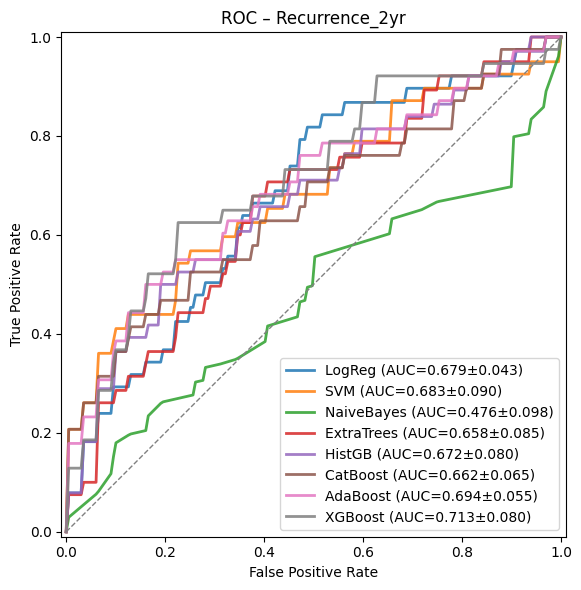

In [23]:
# ╔═╡ Cell 7 – Plot combined ROC figure without Ensemble ══════════════════════╗
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for idx, disp in enumerate(roc_displays):
    # skip the placeholder Ensemble curve
    if "Ensemble" in disp.estimator_name:
        continue

    disp.plot(
        ax=plt.gca(),
        alpha=0.85,
        linewidth=2,
        color=colors[idx % len(colors)]
    )

plt.plot([0, 1], [0, 1], "--", color="grey", linewidth=1)
plt.title("ROC – Recurrence_2yr")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


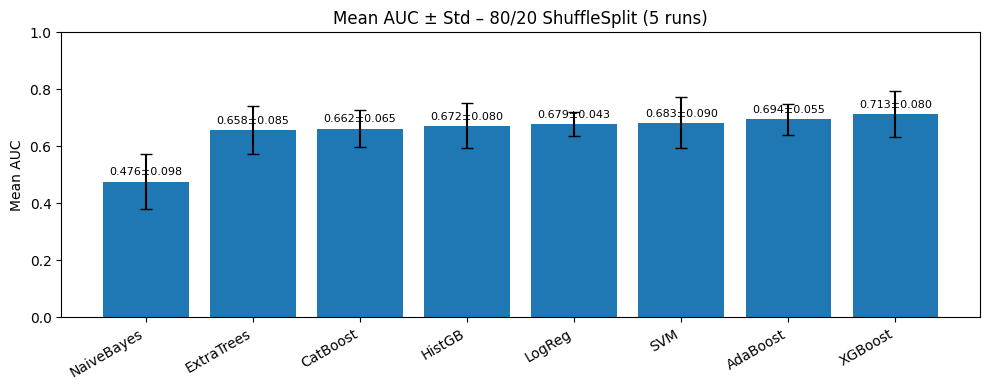

In [24]:
# ╔═╡ Cell 8.1 – Bar chart of mean ShuffleSplit AUCs with ±std ─════════╗
import numpy as np

# 1. Compute mean & std per model
mean_aucs = {name: np.mean(vals) for name, vals in aucs.items()}
std_aucs  = {name: np.std(vals)  for name, vals in aucs.items()}

# 2. Sort by mean AUC
sorted_items = sorted(mean_aucs.items(), key=lambda kv: kv[1])
labels, means = zip(*sorted_items)
stds = [std_aucs[name] for name in labels]

# 3. Plot bars with error bars
plt.figure(figsize=(10, 4))
bars = plt.bar(labels, means, yerr=stds, capsize=4)
plt.ylim(0, 1)
plt.ylabel("Mean AUC")
plt.title("Mean AUC ± Std – 80/20 ShuffleSplit (5 runs)")
plt.xticks(rotation=30, ha="right")

# 4. Annotate each bar with mean±std
for bar, m, s in zip(bars, means, stds):
    text = f"{m:.3f}±{s:.3f}"
    plt.annotate(
        text,
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3), textcoords="offset points",
        ha="center", va="bottom", fontsize=8
    )

plt.tight_layout()
plt.show()


In [25]:
# ╔═╡ Cell 8.2 – Quick summary table with mean ± std AUC (excluding Ensemble) ═══════════╗
import numpy as np
import pandas as pd

# Build a list of records, skipping the Ensemble placeholder
records = []
for name, vals in aucs.items():
    if name == "Ensemble":
        continue
    records.append({
        "Model":    name,
        "Mean AUC": np.mean(vals),
        "Std AUC":  np.std(vals)
    })

# Create DataFrame and sort
summary = (
    pd.DataFrame(records)
      .sort_values("Mean AUC", ascending=False)
      .reset_index(drop=True)
)

# Plain-text print
print(summary.to_string(index=False, float_format="%.3f"))


     Model  Mean AUC  Std AUC
   XGBoost     0.713    0.080
  AdaBoost     0.694    0.055
       SVM     0.683    0.090
    LogReg     0.679    0.043
    HistGB     0.672    0.080
  CatBoost     0.662    0.065
ExtraTrees     0.658    0.085
NaiveBayes     0.476    0.098


AdaBoost AUC: 0.526
Confusion matrix (thr=0.5):
[[63  6]
 [16  0]]

Classification report:
              precision    recall  f1-score   support

           0      0.797     0.913     0.851        69
           1      0.000     0.000     0.000        16

    accuracy                          0.741        85
   macro avg      0.399     0.457     0.426        85
weighted avg      0.647     0.741     0.691        85



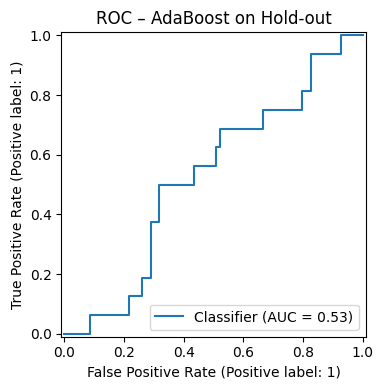

In [26]:
# ╔═╡ Cell 9.1 – AdaBoost on Hold-out ─────────────────────────────────╗
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay
)

# 1) Unpack pipeline and hold-out
ada_pipe = models["AdaBoost"]
X_eval   = X_hold.reset_index(drop=True)
y_eval   = y_hold.reset_index(drop=True).values

# 2) Preprocess (no SMOTE on hold-out)
X_pre = ada_pipe.named_steps["prep"].transform(X_eval)

# 3) Predict & evaluate
y_proba = ada_pipe.named_steps["clf"].predict_proba(X_pre)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print(f"AdaBoost AUC: {roc_auc_score(y_eval, y_proba):.3f}")
print("Confusion matrix (thr=0.5):")
print(confusion_matrix(y_eval, y_pred))
print("\nClassification report:")
print(classification_report(y_eval, y_pred, digits=3))

# 4) ROC curve
fig, ax = plt.subplots(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_eval, y_proba, ax=ax)
ax.set_title("ROC – AdaBoost on Hold-out")
plt.tight_layout()
plt.show()


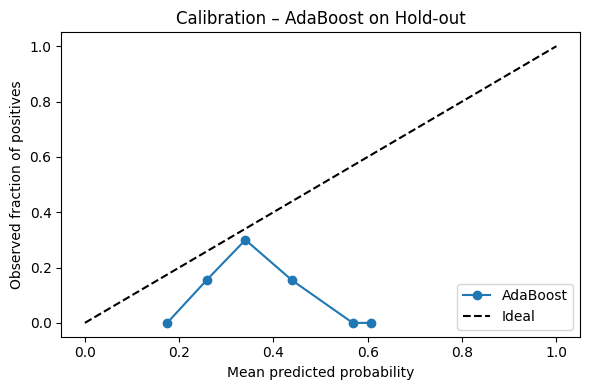

Brier score: 0.1850


In [27]:
# ╔═╡ Cell 9.2 – Calibration Curve + Brier Score for AdaBoost ─────────────╗
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics      import brier_score_loss

# assumes y_eval and y_proba from Cell 9.1
frac, mean_pred = calibration_curve(
    y_eval, y_proba, n_bins=10, strategy="uniform"
)

plt.figure(figsize=(6, 4))
plt.plot(mean_pred, frac, marker="o", label="AdaBoost")
plt.plot([0, 1], [0, 1], "k--", label="Ideal")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed fraction of positives")
plt.title("Calibration – AdaBoost on Hold-out")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Brier score: {brier_score_loss(y_eval, y_proba):.4f}")


<ipython-input-28-e0201e25848d>:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


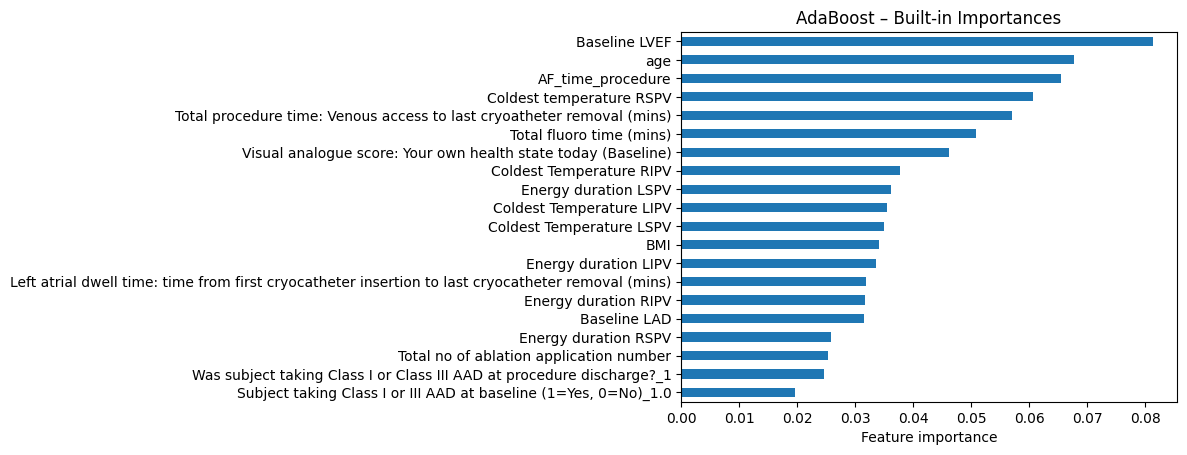

In [28]:
# ╔═╡ Cell 9.3 – AdaBoost Built-in Feature Importances ─────────────────╗
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# 1) Get the preprocessing step from your AdaBoost pipeline
ada_pipe = models["AdaBoost"]  # ImbPipeline(prep → SMOTE → AdaBoost)
prep     = ada_pipe.named_steps["prep"]

# 2) Build the list of transformed feature names
feat_names = []
for name, transformer, cols in prep.transformers_:
    if transformer == "drop":
        continue

    # If this transformer is itself a Pipeline, grab its last step
    if isinstance(transformer, Pipeline):
        transformer = transformer.steps[-1][1]

    # Now ask for feature names
    if hasattr(transformer, "get_feature_names_out"):
        try:
            names = transformer.get_feature_names_out(cols)
        except TypeError:
            # Some versions ignore the `cols` argument
            names = transformer.get_feature_names_out()
    else:
        # Fallback: use the original column names
        names = cols

    feat_names.extend(names)

# 3) Pull out AdaBoost’s feature_importances_
importances = ada_pipe.named_steps["clf"].feature_importances_

# 4) Map importances to feature names and plot the top 20
imp_ser = pd.Series(importances, index=feat_names).sort_values()
imp_ser.tail(20).plot.barh()
plt.xlabel("Feature importance")
plt.title("AdaBoost – Built-in Importances")
plt.tight_layout()
plt.show()


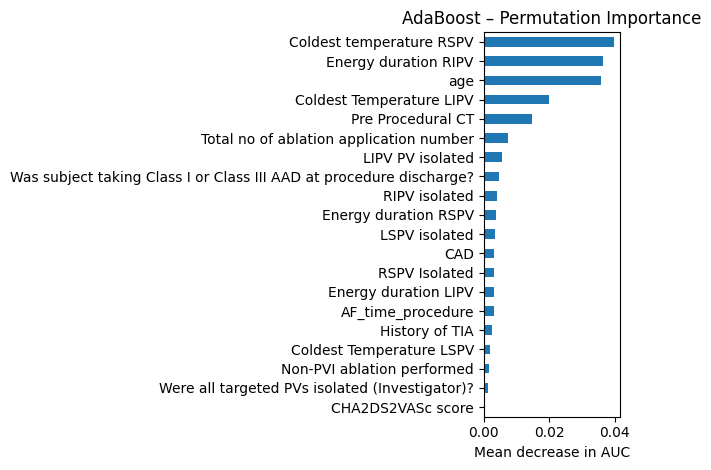

In [29]:
# ╔═╡ Cell 9.4 – Permutation Importance for AdaBoost ──────────────────╗
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 1) Compute permutation importance on the original feature set
perm = permutation_importance(
    ada_pipe,
    X_eval,
    y_eval,
    scoring="roc_auc",
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# 2) Map importances back to the original features
orig_feats = X_eval.columns.tolist()
perm_ser   = pd.Series(perm.importances_mean, index=orig_feats).sort_values()

# 3) Plot the top 20 most important original features
perm_ser.tail(20).plot.barh()
plt.xlabel("Mean decrease in AUC")
plt.title("AdaBoost – Permutation Importance")
plt.tight_layout()
plt.show()


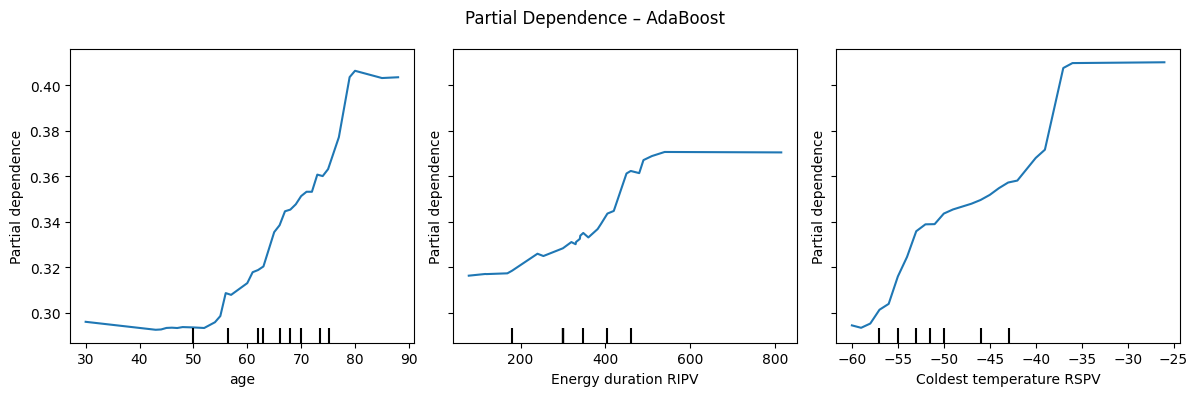

In [30]:
# ╔═╡ Cell 9.5 – Partial Dependence for Top-3 AdaBoost Features ───────╗
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1) Pick top-3 from permutation importances
top3 = perm_ser.tail(3).index.tolist()

# 2) Plot PDPs
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
PartialDependenceDisplay.from_estimator(
    ada_pipe, X_eval, features=top3,
    kind="average", ax=axes
)
plt.suptitle("Partial Dependence – AdaBoost")
plt.tight_layout()
plt.show()


  0%|          | 0/85 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
<ipython-input-31-71ce3bcc42dd>:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


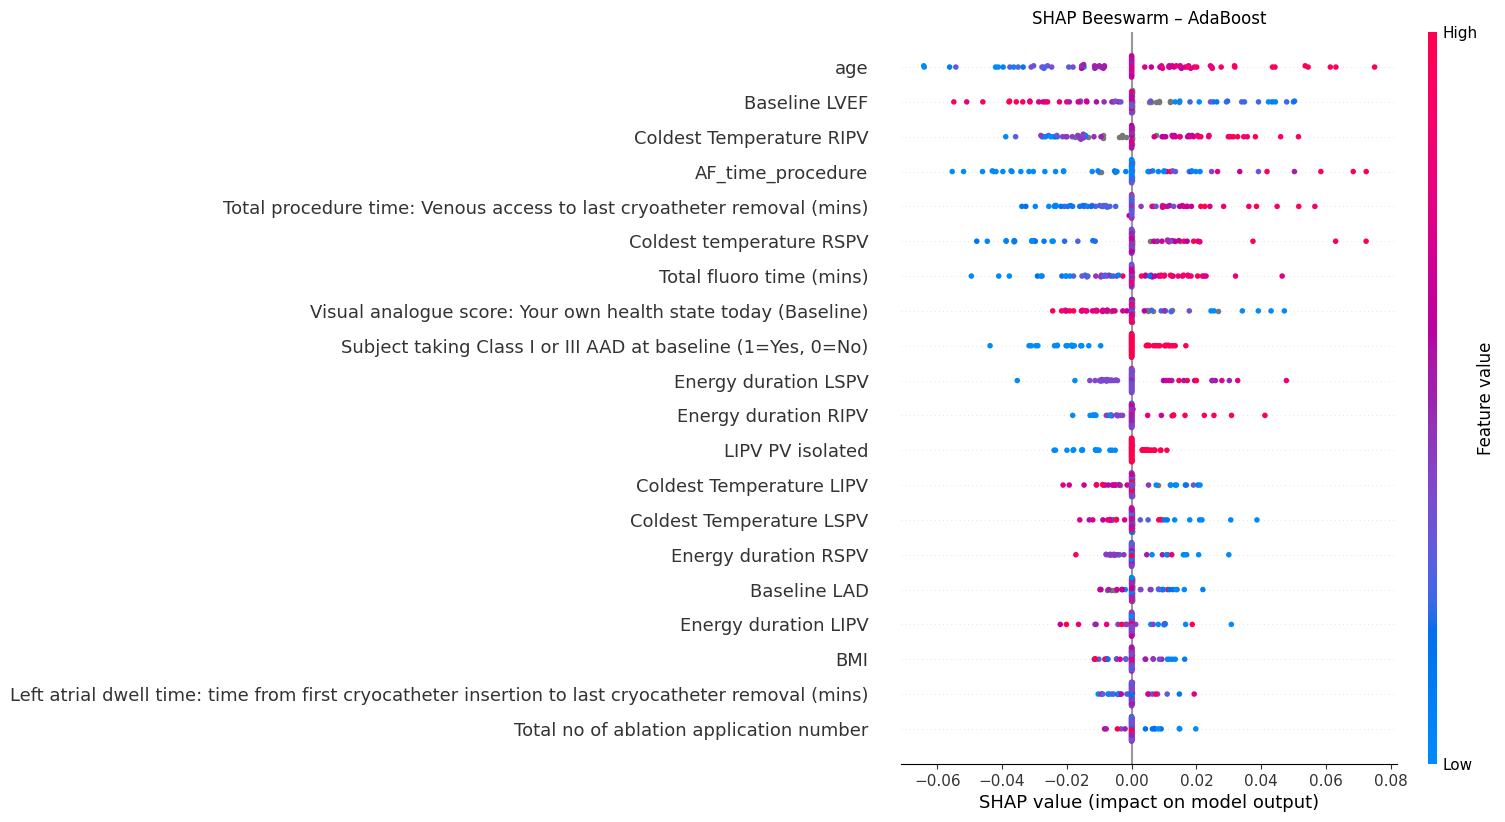

In [31]:
# ╔═╡ Cell 9.6 – SHAP Summary for AdaBoost (model-agnostic) ─════════════╗
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare hold-out set
X_eval = X_hold.reset_index(drop=True)

# 1) Prediction wrapper that handles DataFrame or ndarray
def ada_proba(data):
    if isinstance(data, np.ndarray):
        df = pd.DataFrame(data, columns=X_eval.columns)
    else:
        df = data.copy()
    X_trans = ada_pipe.named_steps["prep"].transform(df)
    return ada_pipe.named_steps["clf"].predict_proba(X_trans)[:, 1]

# 2) Background sample for Kernel SHAP
bg = shap.sample(X_eval, 100, random_state=RANDOM_STATE)

# 3) Instantiate KernelExplainer
explainer = shap.KernelExplainer(ada_proba, bg)

# 4) Compute SHAP values on the hold-out (reduce nsamples if slow)
shap_vals = explainer.shap_values(X_eval, nsamples=200)

# 5) Beeswarm summary plot
plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_vals,
    X_eval,
    feature_names=X_eval.columns.tolist(),
    plot_type="dot",
    max_display=20,
    show=False
)
plt.title("SHAP Beeswarm – AdaBoost")
plt.tight_layout()
plt.show()


In [32]:
# ╔═╡ Cell 10.0 – Bootstrap AUC with 95% CI on the hold-out set ─────────────────╗
import numpy as np
from sklearn.metrics import roc_auc_score

# 1) Ground truth & predicted probabilities on hold-out
y_true = y_hold.reset_index(drop=True)
X_eval = X_hold.reset_index(drop=True)
y_prob = models["XGBoost"].predict_proba(X_eval)[:, 1]

# 2) Bootstrap settings
n_bootstraps = 1000
rng = np.random.RandomState(42)
boot_scores = []

# 3) Draw bootstrap samples and compute AUC
for _ in range(n_bootstraps):
    idxs = rng.choice(len(y_true), size=len(y_true), replace=True)
    y_samp = y_true.iloc[idxs]
    p_samp = y_prob[idxs]
    # skip if only one class in sample
    if y_samp.nunique() < 2:
        continue
    boot_scores.append(roc_auc_score(y_samp, p_samp))

# 4) Aggregate results
auc_mean   = roc_auc_score(y_true, y_prob)
ci_lower, ci_upper = np.percentile(boot_scores, [2.5, 97.5])

# 5) Report
print(f"Hold-out AUC           = {auc_mean:.3f}")
print(f"95% CI (bootstrap) = [{ci_lower:.3f}, {ci_upper:.3f}]")


Hold-out AUC           = 0.579
95% CI (bootstrap) = [0.446, 0.724]


In [33]:
# ╔═╡ Cell 10.1 – Pipeline + sigmoid calibration ─────────────────────╗
from sklearn.pipeline            import Pipeline
from sklearn.calibration        import CalibratedClassifierCV
from xgboost                    import XGBClassifier

# 1) Build an XGB pipeline WITHOUT early stopping
#    This uses the same hyperparameters you found in Cell 5.4 (best_params).
xgb_pipe_uncal = Pipeline([
    ("prep", pre_xgb),  # your simple median‐imputer + ordinal‐encoder ColumnTransformer
    ("clf",  XGBClassifier(
        **best_params,               # from your RandomizedSearchCV in Cell 5.4
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        random_state=RANDOM_STATE
        # <— NO early_stopping_rounds here!
    ))
])

# 2) Wrap in a Platt‐scaler (sigmoid) using 5‐fold CV on the full training set
calibrator = CalibratedClassifierCV(
    estimator=xgb_pipe_uncal,
    method="sigmoid",  # Platt scaling
    cv=5
)

# 3) Fit on your entire training set
calibrator.fit(X_train, y_train)

# 4) Store back into your models dict
models["XGBoost_Calibrated"] = calibrator

print("✅ Calibrated XGBoost fitted with sigmoid scaling (5‐fold CV).")


✅ Calibrated XGBoost fitted with sigmoid scaling (5‐fold CV).


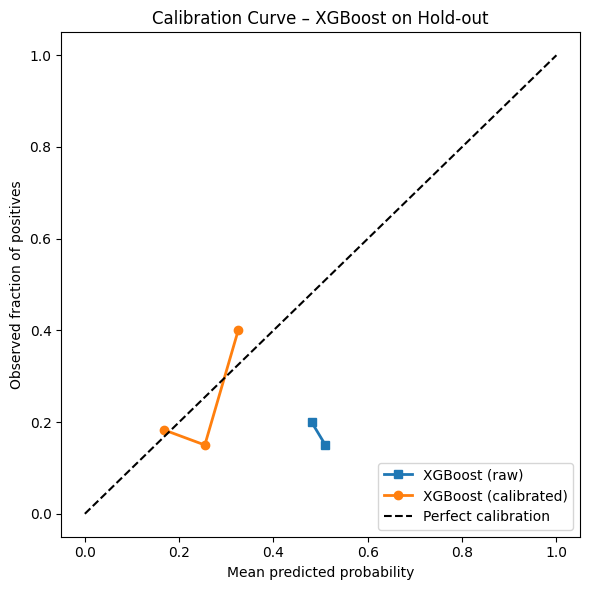

Brier score (raw)        = 0.2417
Brier score (calibrated) = 0.1516


In [34]:
# ╔═╡ Cell 10.2 – Calibration curve + Brier score on the hold‐out set ─────────────╢
from sklearn.calibration import calibration_curve
from sklearn.metrics      import brier_score_loss
import matplotlib.pyplot as plt

# 1) Ground truth & predicted probabilities on hold‐out
y_true      = y_hold.reset_index(drop=True)
X_eval      = X_hold.reset_index(drop=True)
y_prob_raw  = models["XGBoost"]           .predict_proba(X_eval)[:, 1]
y_prob_cal  = models["XGBoost_Calibrated"].predict_proba(X_eval)[:, 1]

# 2) Compute calibration curves
#    - using uniform bins ensures equal-width probability intervals
frac_pos_raw, mean_pred_raw = calibration_curve(
    y_true, y_prob_raw, n_bins=10, strategy="uniform"
)
frac_pos_cal, mean_pred_cal = calibration_curve(
    y_true, y_prob_cal, n_bins=10, strategy="uniform"
)

# 3) Plot
plt.figure(figsize=(6, 6))
plt.plot(mean_pred_raw, frac_pos_raw, marker="s", linewidth=2, label="XGBoost (raw)")
plt.plot(mean_pred_cal, frac_pos_cal, marker="o", linewidth=2, label="XGBoost (calibrated)")
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed fraction of positives")
plt.title("Calibration Curve – XGBoost on Hold-out")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 4) Brier scores
bs_raw = brier_score_loss(y_true, y_prob_raw)
bs_cal = brier_score_loss(y_true, y_prob_cal)
print(f"Brier score (raw)        = {bs_raw:.4f}")
print(f"Brier score (calibrated) = {bs_cal:.4f}")


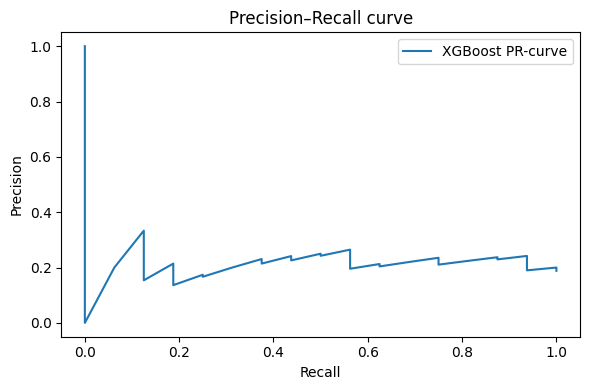

Best F1=0.385 at threshold=0.48


In [35]:
# ╔═╡ Cell 10.3 – Precision–Recall & threshold‐tuning ════════════════╗
from sklearn.metrics import precision_recall_curve, f1_score

y_prob = models["XGBoost"].predict_proba(X_hold)[:,1]
precision, recall, thresholds = precision_recall_curve(y_hold, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="XGBoost PR-curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()
plt.tight_layout()
plt.show()

# F1 vs threshold
f1s = [f1_score(y_hold, y_prob>=t) for t in thresholds]
opt_idx = np.argmax(f1s)
print(f"Best F1={f1s[opt_idx]:.3f} at threshold={thresholds[opt_idx]:.2f}")


  0%|          | 0/85 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
<ipython-input-36-1891ddc3b245>:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


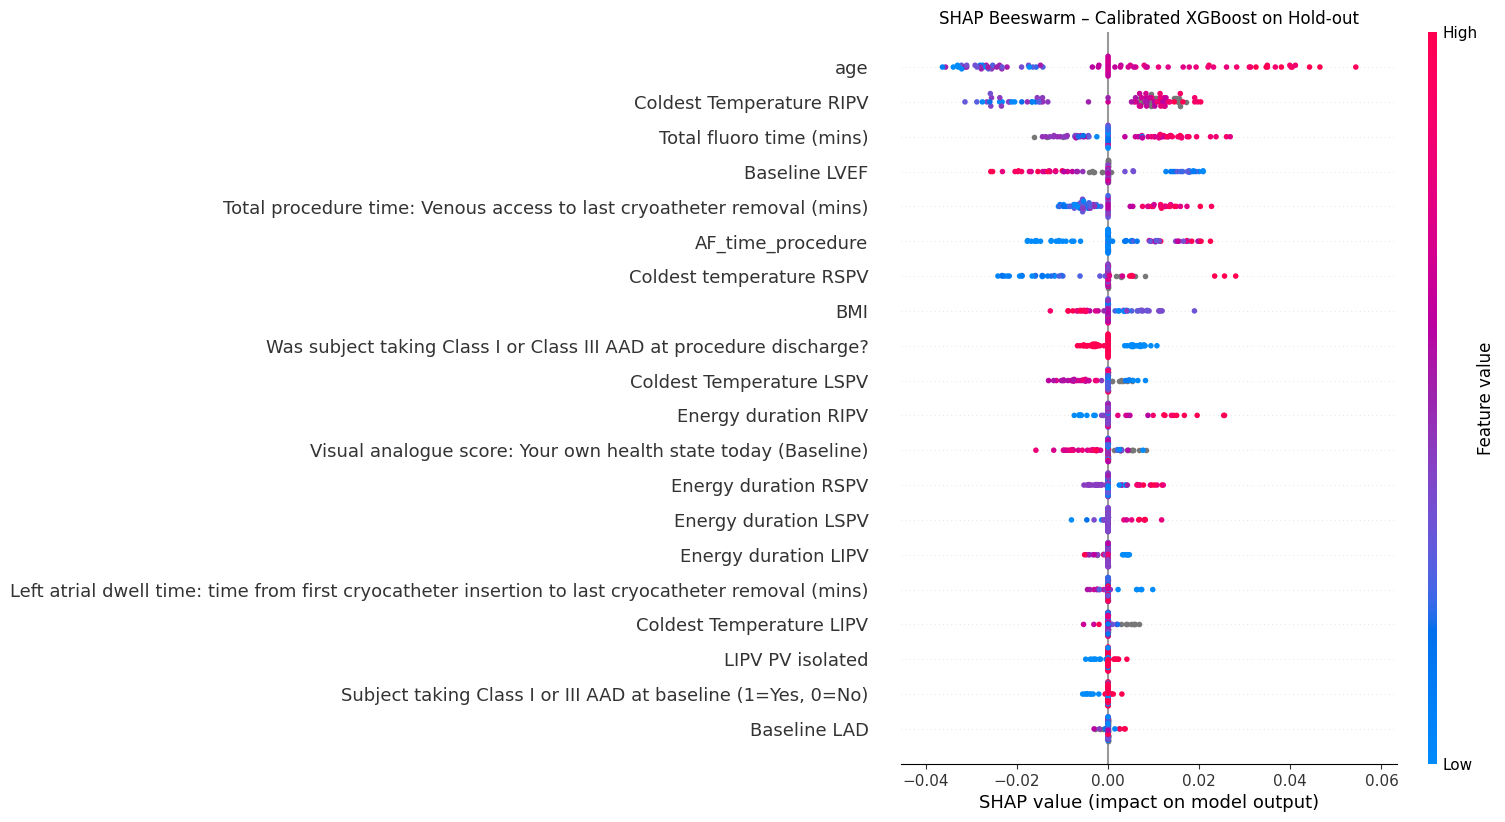

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
<ipython-input-36-1891ddc3b245>:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


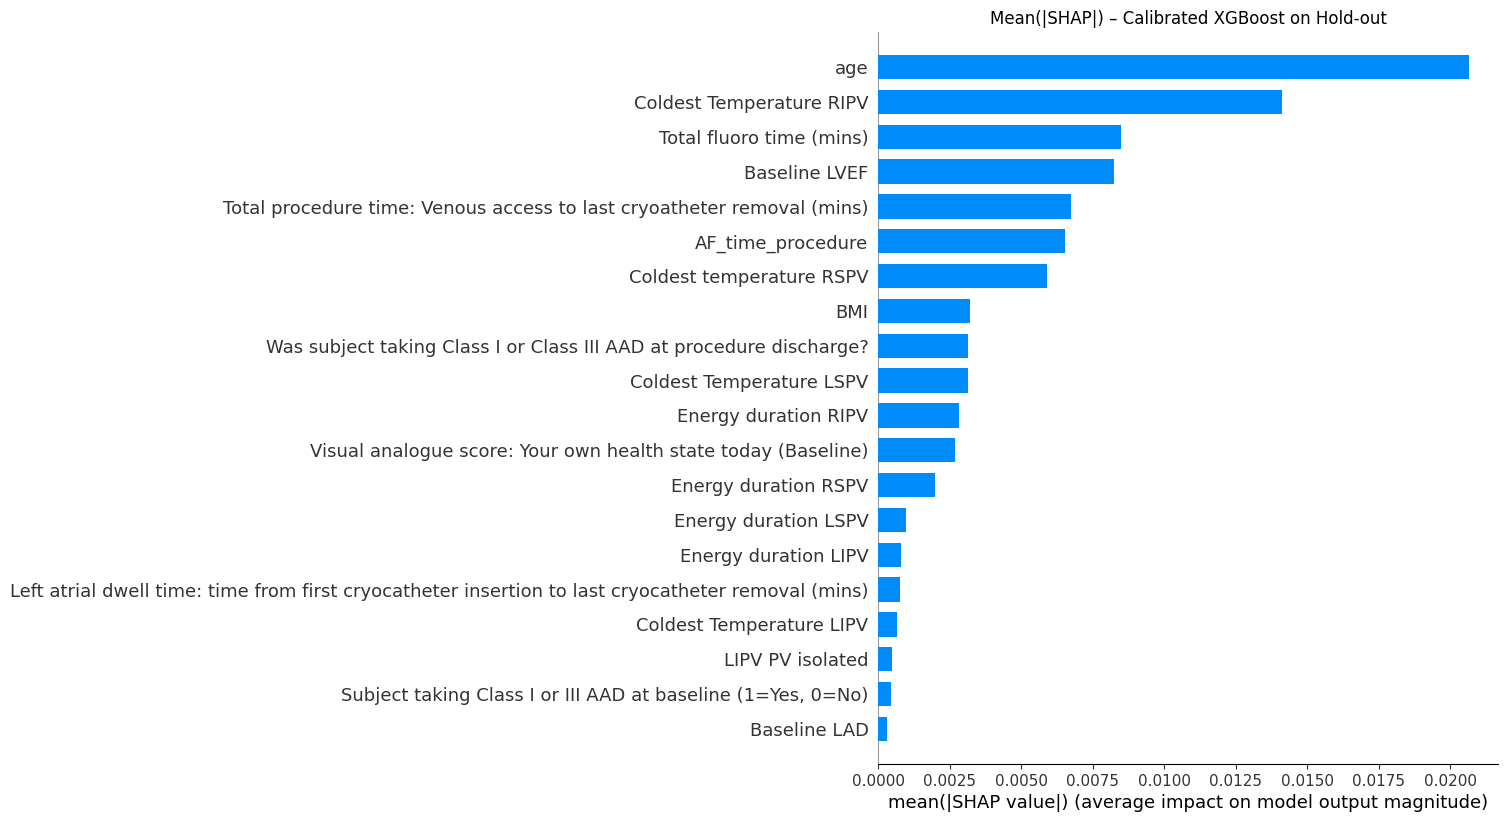

In [36]:
# ╔═╡ Cell 10.4 – Model-agnostic SHAP (Calibrated XGBoost + KernelExplainer) ─────────╗
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Unpack the sigmoid-calibrated XGBoost pipeline
calibrated_pipe = models["XGBoost_Calibrated"]

# 2) Feature names for converting arrays back to DataFrame
feature_names = X_train.columns.tolist()

# 3) Prediction wrapper: accepts np.ndarray or pd.DataFrame
def model_predict(data):
    if isinstance(data, np.ndarray):
        df = pd.DataFrame(data, columns=feature_names)
    else:
        df = data.copy()
    return calibrated_pipe.predict_proba(df)[:, 1]

# 4) Background sample (100 rows) from training set for Kernel SHAP
bg_data = shap.sample(X_train, 100, random_state=RANDOM_STATE)

# 5) Instantiate model-agnostic explainer
explainer = shap.KernelExplainer(model_predict, bg_data)

# 6) Compute SHAP values on your hold-out set
X_eval = X_hold.reset_index(drop=True)
shap_vals = explainer.shap_values(X_eval, nsamples=200)

# 7) Beeswarm (dot) summary on probability scale
sv = np.array(shap_vals)
lo, hi = sv.min(), sv.max()
margin = 0.1 * (hi - lo)

plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_vals,
    X_eval,
    feature_names=feature_names,
    plot_type="dot",
    max_display=20,
    show=False
)
plt.xlim(lo - margin, hi + margin)
plt.title("SHAP Beeswarm – Calibrated XGBoost on Hold-out")
plt.tight_layout()
plt.show()

# 8) Bar plot of mean(|SHAP|)
plt.figure(figsize=(6, 8))
shap.summary_plot(
    shap_vals,
    X_eval,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("Mean(|SHAP|) – Calibrated XGBoost on Hold-out")
plt.tight_layout()
plt.show()


Top 3 features by |SHAP|: ['age', 'Coldest Temperature RIPV', 'Total fluoro time (mins)']


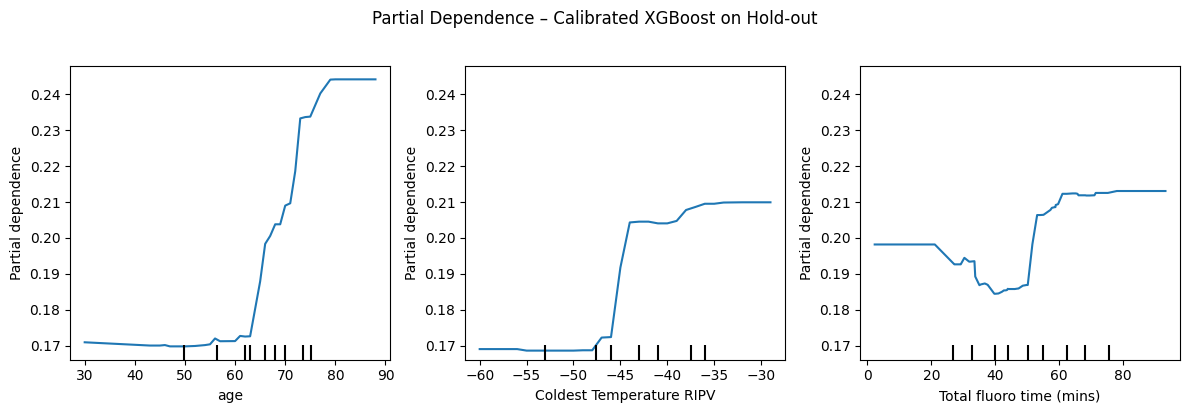

In [37]:
# ╔═╡ Cell 10.5 – Partial dependence for top 3 features (Calibrated XGBoost) ══════════╗
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1) Prepare evaluation data (hold-out)
X_eval = X_hold.reset_index(drop=True)

# 2) Unpack the calibrated pipeline
calibrated_pipe = models["XGBoost_Calibrated"]

# 3) Extract SHAP values array from Cell 10.4
#    shap_vals may be [class0, class1] or a 2D array
if isinstance(shap_vals, list):
    shap_array = np.array(shap_vals[1])  # positive-class contributions
else:
    shap_array = np.array(shap_vals)

# 4) Compute mean absolute SHAP importances and select top 3
importances  = np.mean(np.abs(shap_array), axis=0)
top_indices  = np.argsort(importances)[::-1][:3]
top_features = [X_eval.columns[i] for i in top_indices]
print("Top 3 features by |SHAP|:", top_features)

# 5) Plot partial dependence for those top features
fig, axes = plt.subplots(1, len(top_features), figsize=(4 * len(top_features), 4))
PartialDependenceDisplay.from_estimator(
    calibrated_pipe,
    X_eval,
    features=top_features,
    kind="average",
    ax=axes
)
plt.suptitle("Partial Dependence – Calibrated XGBoost on Hold-out", y=1.02)
plt.tight_layout()
plt.show()


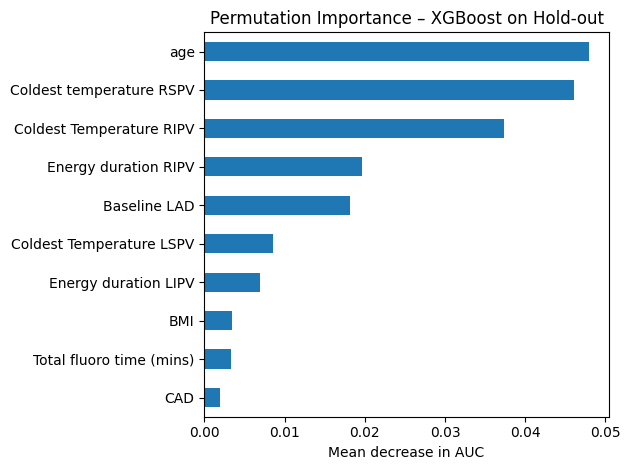

In [38]:
# ╔═╡ Cell 10.6 – Permutation importance on hold‐out set ─────────────────────────╗
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 1) Prepare hold‐out data
X_eval = X_hold.reset_index(drop=True)
y_eval = y_hold.reset_index(drop=True)

# 2) Compute permutation importance (mean decrease in AUC)
r = permutation_importance(
    models["XGBoost"],
    X_eval,
    y_eval,
    scoring="roc_auc",
    n_repeats=10,
    random_state=RANDOM_STATE
)

# 3) Create a Series and sort ascending for horizontal bar plot
perm_df = pd.Series(r.importances_mean, index=X_eval.columns).sort_values(ascending=True)

# 4) Plot the top 10 features
perm_df.tail(10).plot.barh()
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation Importance – XGBoost on Hold‐out")
plt.tight_layout()
plt.show()


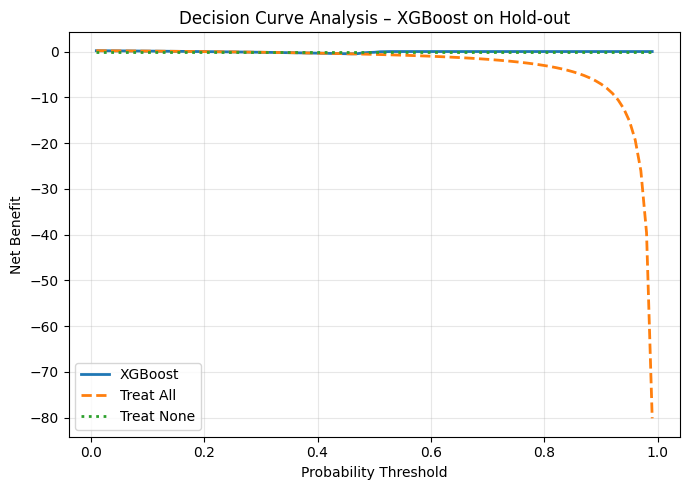

In [39]:
# ╔═╡ Cell 10.7 – Decision Curve Analysis (Net Benefit) on Hold-out ───────────────╢
import numpy as np
import matplotlib.pyplot as plt

# 1) Ground truth & predicted probabilities on the hold-out set
y_true = y_hold.reset_index(drop=True).values
X_eval = X_hold.reset_index(drop=True)
y_prob = models["XGBoost"].predict_proba(X_eval)[:, 1]

N      = len(y_true)
preval = y_true.mean()

# 2) Define a grid of decision thresholds
thresholds = np.linspace(0.01, 0.99, 99)

# 3) Compute net benefit for model, Treat All, and Treat None
nb_model = []
nb_all   = []
nb_none  = np.zeros_like(thresholds)

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    TP    = ((preds == 1) & (y_true == 1)).sum()
    FP    = ((preds == 1) & (y_true == 0)).sum()
    # Net benefit = TP/N - (FP/N) * (t / (1 - t))
    nb_model.append(TP/N - FP/N * (t / (1 - t)))
    # Treat All net benefit = prevalence - (1 - prevalence)*(t/(1-t))
    nb_all.append(preval - (1 - preval) * (t / (1 - t)))

# 4) Plot the decision curves
plt.figure(figsize=(7, 5))
plt.plot(thresholds, nb_model, label="XGBoost",    linewidth=2)
plt.plot(thresholds, nb_all,   label="Treat All",  linestyle="--", linewidth=2)
plt.plot(thresholds, nb_none,  label="Treat None", linestyle=":",  linewidth=2)
plt.xlabel("Probability Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis – XGBoost on Hold-out")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Final AUC                         : 0.624
Confusion matrix (threshold=0.5):
[[69  0]
 [16  0]]

Classification report:
              precision    recall  f1-score   support

           0      0.812     1.000     0.896        69
           1      0.000     0.000     0.000        16

    accuracy                          0.812        85
   macro avg      0.406     0.500     0.448        85
weighted avg      0.659     0.812     0.727        85



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


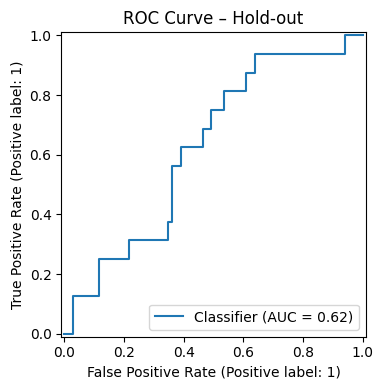

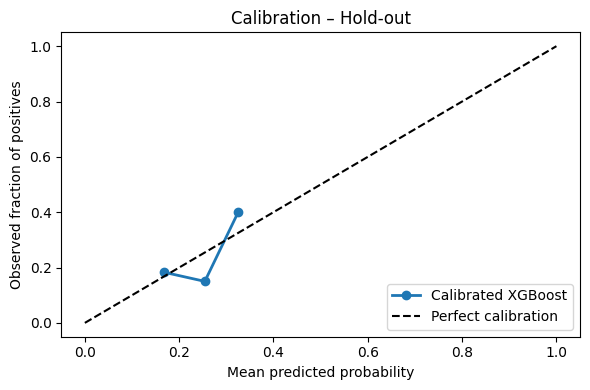

Final Brier score                 : 0.1516
Optimal threshold (Youden's J)    : 0.166

Confusion matrix (optimal thr):
[[25 44]
 [ 1 15]]

Classification report (optimal thr):
              precision    recall  f1-score   support

           0      0.962     0.362     0.526        69
           1      0.254     0.938     0.400        16

    accuracy                          0.471        85
   macro avg      0.608     0.650     0.463        85
weighted avg      0.828     0.471     0.503        85



In [40]:
# ╔═╡ Cell 10.8 – Final evaluation on hold‐out set ─════════════════════════╗
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay,
    brier_score_loss, roc_curve
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# 1) Select your final calibrated model
best_model = models["XGBoost_Calibrated"]

# 2) Prepare hold‐out data
X_eval = X_hold.reset_index(drop=True)
y_eval = y_hold.reset_index(drop=True)

# 3) Predict probabilities and hard labels at 0.5
y_prob = best_model.predict_proba(X_eval)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# 4) Print summary metrics
print(f"Final AUC                         : {roc_auc_score(y_eval, y_prob):.3f}")
print("Confusion matrix (threshold=0.5):")
print(confusion_matrix(y_eval, y_pred))
print("\nClassification report:")
print(classification_report(y_eval, y_pred, digits=3))

# 5) Plot ROC curve
fig, ax = plt.subplots(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_eval, y_prob, ax=ax)
ax.set_title("ROC Curve – Hold‐out")
plt.tight_layout()
plt.show()

# 6) Calibration curve + Brier score
frac_pos, mean_pred = calibration_curve(
    y_eval, y_prob, n_bins=10, strategy="uniform"
)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(mean_pred, frac_pos, marker="o", linewidth=2, label="Calibrated XGBoost")
ax.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed fraction of positives")
ax.set_title("Calibration – Hold‐out")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Final Brier score                 : {brier_score_loss(y_eval, y_prob):.4f}")

# 7) Optimal threshold via Youden's J
fpr, tpr, thresholds = roc_curve(y_eval, y_prob)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thr = thresholds[best_idx]
print(f"Optimal threshold (Youden's J)    : {best_thr:.3f}")

# 8) Metrics at optimal threshold
y_opt = (y_prob >= best_thr).astype(int)
print("\nConfusion matrix (optimal thr):")
print(confusion_matrix(y_eval, y_opt))
print("\nClassification report (optimal thr):")
print(classification_report(y_eval, y_opt, digits=3))


Bootstrap-Calibrated XGB AUC:        0.5643115942028986
Confusion matrix @0.5:
 [[65  4]
 [14  2]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        69
           1       0.33      0.12      0.18        16

    accuracy                           0.79        85
   macro avg       0.58      0.53      0.53        85
weighted avg       0.73      0.79      0.75        85



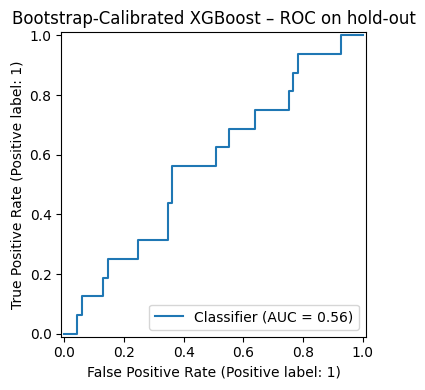

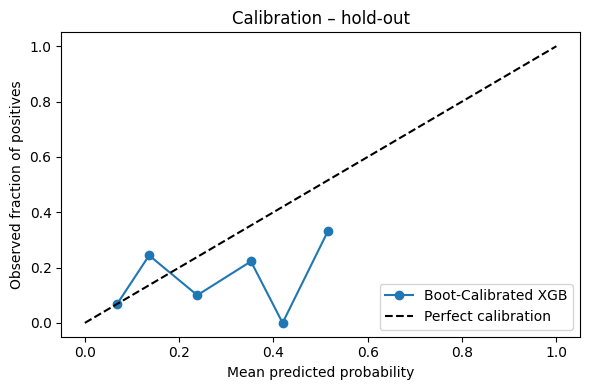

Bootstrap-Calibrated XGB Brier score: 0.16218593255878044
Optimal threshold (Youden’s J):      0.180


In [41]:
# ╔═╡ Cell 10.9 – Bootstrap-Calibrated XGBoost on hold-out ─────────────────╗
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils           import resample
from sklearn.base            import clone
from sklearn.metrics         import (
    roc_auc_score, roc_curve,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    brier_score_loss
)
from sklearn.calibration     import CalibratedClassifierCV, calibration_curve

# 1) Settings
n_boot    = 20
X_eval    = X_hold.reset_index(drop=True)
y_eval    = y_hold.reset_index(drop=True)
boot_preds = np.zeros((len(X_eval), n_boot))

# 2) Bootstrap loop: resample train → clone XGB → disable its early stopping → calibrate → predict
for i in range(n_boot):
    Xb, yb = resample(X_train, y_train, random_state=RANDOM_STATE + i)
    pipe_uncal = clone(models["XGBoost"])
    # turn off early stopping so .fit() works without a validation set
    pipe_uncal.set_params(clf__early_stopping_rounds=None)
    calib = CalibratedClassifierCV(pipe_uncal, method="sigmoid", cv=3)
    calib.fit(Xb, yb)
    boot_preds[:, i] = calib.predict_proba(X_eval)[:, 1]

# 3) Aggregate probabilities & derive hard predictions
y_mean = boot_preds.mean(axis=1)
y_pred = (y_mean >= 0.5).astype(int)

# 4) Discrimination & classification metrics
print("Bootstrap-Calibrated XGB AUC:       ", roc_auc_score(y_eval, y_mean))
print("Confusion matrix @0.5:\n", confusion_matrix(y_eval, y_pred))
print("\nClassification report:\n", classification_report(y_eval, y_pred))

# 5) ROC curve
fig, ax = plt.subplots(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_eval, y_mean, ax=ax)
ax.set_title("Bootstrap-Calibrated XGBoost – ROC on hold-out")
plt.tight_layout()
plt.show()

# 6) Calibration curve + Brier score
frac_pos, mean_pred = calibration_curve(
    y_eval, y_mean, n_bins=10, strategy="uniform"
)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(mean_pred, frac_pos, "o-", label="Boot-Calibrated XGB")
ax.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed fraction of positives")
ax.set_title("Calibration – hold-out")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()
print("Bootstrap-Calibrated XGB Brier score:", brier_score_loss(y_eval, y_mean))

# 7) Optimal threshold via Youden’s J
fpr, tpr, threshs = roc_curve(y_eval, y_mean)
j_scores = tpr - fpr
best_thr = threshs[np.argmax(j_scores)]
print(f"Optimal threshold (Youden’s J):      {best_thr:.3f}")


🔎 SHAP values shape: (85, 41)


/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
<ipython-input-42-5e67dae9e81e>:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


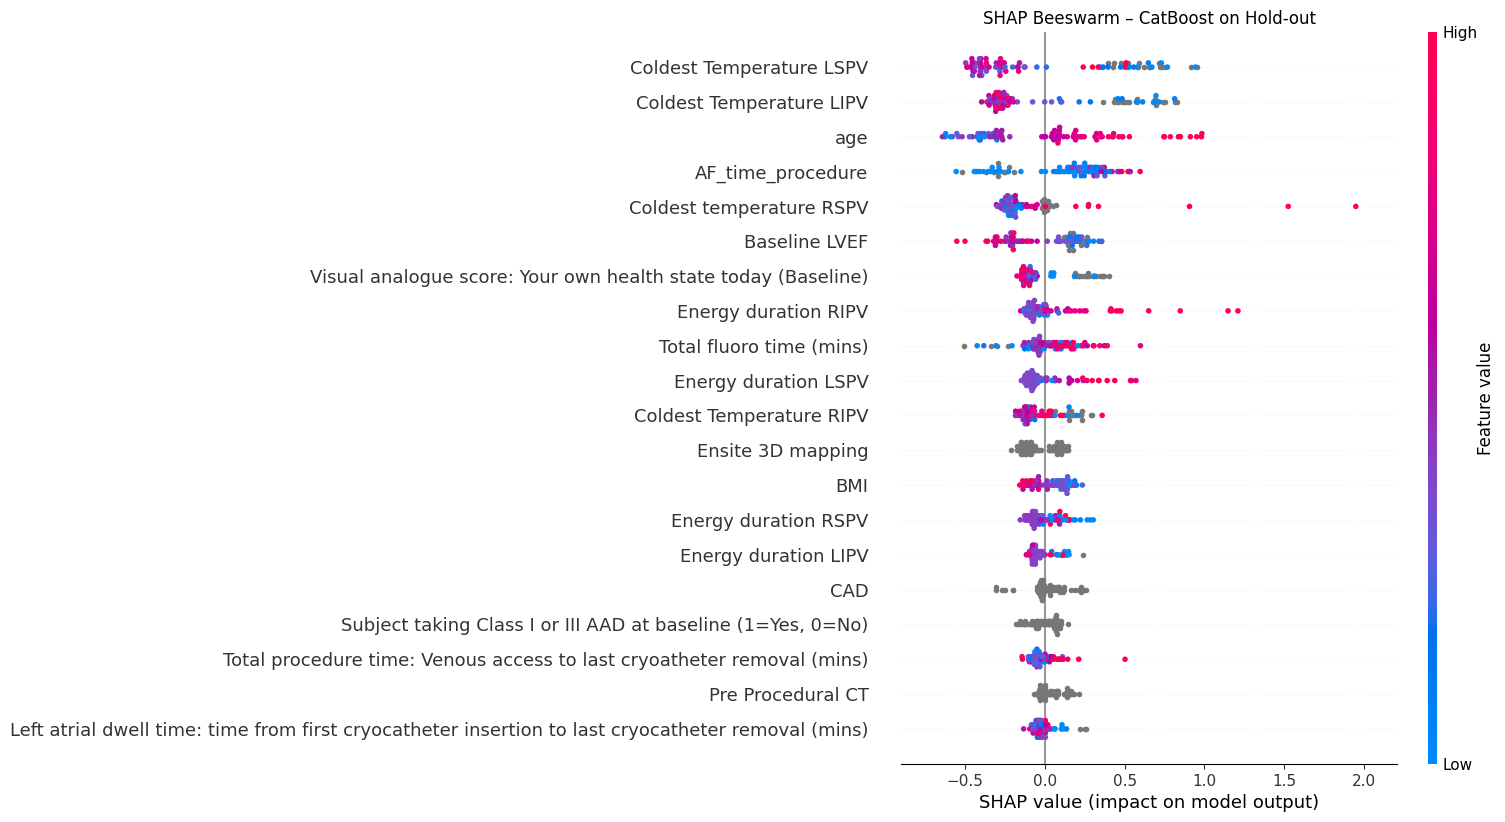

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
<ipython-input-42-5e67dae9e81e>:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


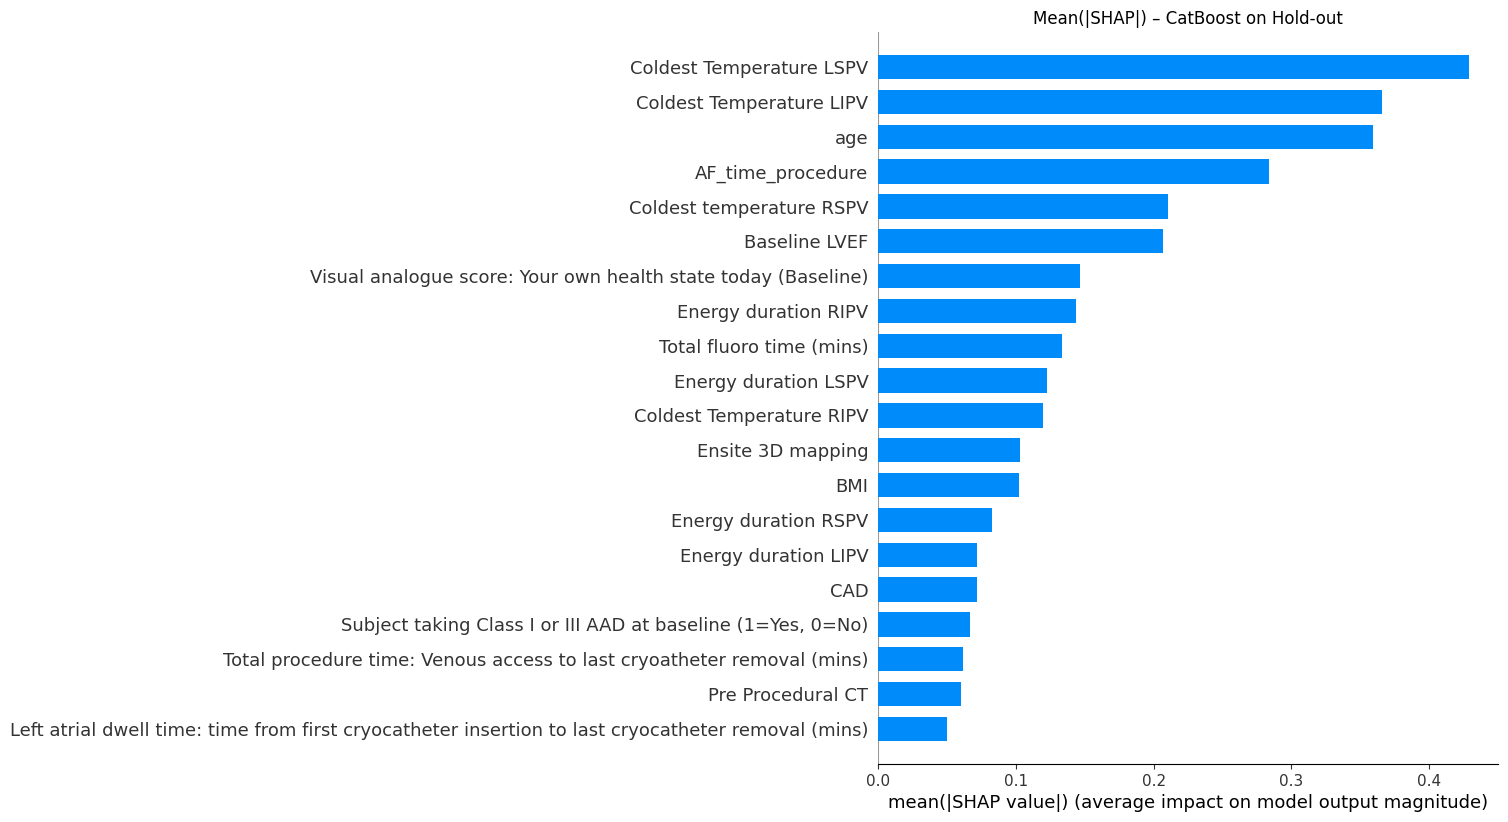

In [42]:
# ╔═╡ Cell 11.0 – SHAP summary for CatBoost on hold-out ─══════════════════╗
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1) Extract the trained CatBoost model
cb_entry = models["CatBoost"]
cb_model = (
    cb_entry.named_steps["clf"]
    if hasattr(cb_entry, "named_steps")
    else cb_entry
)

# 2) Prepare hold-out data exactly as CatBoost expects
X_cb_hold = prepare_for_catboost(X_hold, cat)

# 3) Create a TreeExplainer using exact tree paths
explainer_cb = shap.TreeExplainer(
    cb_model,
    feature_perturbation="tree_path_dependent"
)

# 4) Compute SHAP values for the positive class
shap_vals = explainer_cb.shap_values(X_cb_hold)
print("🔎 SHAP values shape:", np.array(shap_vals).shape)

# 5) Determine global SHAP range with a 10% margin for plotting
all_vals = np.array(shap_vals)
vmin, vmax = all_vals.min(), all_vals.max()
padding = 0.1 * (vmax - vmin)

# 6) Beeswarm summary plot
plt.figure(figsize=(16, 6))
shap.summary_plot(
    shap_vals,
    X_cb_hold,
    feature_names=X_hold.columns.tolist(),
    plot_type="dot",
    max_display=20,
    show=False
)
plt.xlim(vmin - padding, vmax + padding)
plt.title("SHAP Beeswarm – CatBoost on Hold-out")
plt.tight_layout()
plt.show()

# 7) Bar chart of mean absolute SHAP values
plt.figure(figsize=(6, 8))
shap.summary_plot(
    shap_vals,
    X_cb_hold,
    feature_names=X_hold.columns.tolist(),
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("Mean(|SHAP|) – CatBoost on Hold-out")
plt.tight_layout()
plt.show()


Top 3 CatBoost features: ['Coldest Temperature LSPV', 'Coldest Temperature LIPV', 'age']


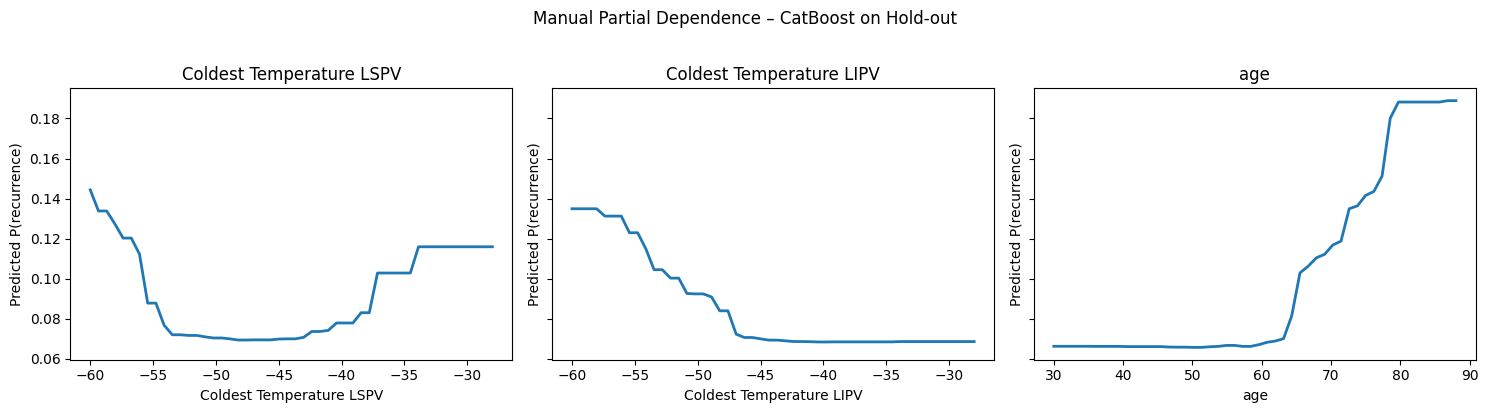

In [43]:
# ╔═╡ Cell 11.1 – Manual Partial Dependence (top 3 CatBoost features) ─════════╝
import numpy as np
import matplotlib.pyplot as plt

# 1) Extract the trained CatBoost model
cb_entry = models["CatBoost"]
cb_model = (
    cb_entry.named_steps["clf"]
    if hasattr(cb_entry, "named_steps")
    else cb_entry
)

# 2) Prepare the hold-out data exactly as CatBoost expects
X_cb_hold = prepare_for_catboost(X_hold, cat)
feature_names = X_cb_hold.columns.tolist()

# 3) Compute mean(|SHAP|) importances from the shap_vals array
shap_arr = np.array(shap_vals)  # shap_vals from Cell 11.0
importances = np.mean(np.abs(shap_arr), axis=0)
top3_idx = np.argsort(importances)[::-1][:3]
top3_feats = [feature_names[i] for i in top3_idx]
print("Top 3 CatBoost features:", top3_feats)

# 4) Compute and plot partial dependence manually for each top feature
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, feat in zip(axes, top3_feats):
    grid = np.linspace(X_cb_hold[feat].min(), X_cb_hold[feat].max(), 50)
    pdp = []
    for val in grid:
        X_temp = X_cb_hold.copy()
        X_temp[feat] = val
        pdp.append(cb_model.predict_proba(X_temp)[:, 1].mean())
    ax.plot(grid, pdp, linewidth=2)
    ax.set_xlabel(feat)
    ax.set_ylabel("Predicted P(recurrence)")
    ax.set_title(feat)

plt.suptitle("Manual Partial Dependence – CatBoost on Hold-out", y=1.02)
plt.tight_layout()
plt.show()


<ipython-input-44-c6f3f9aea1ae>:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


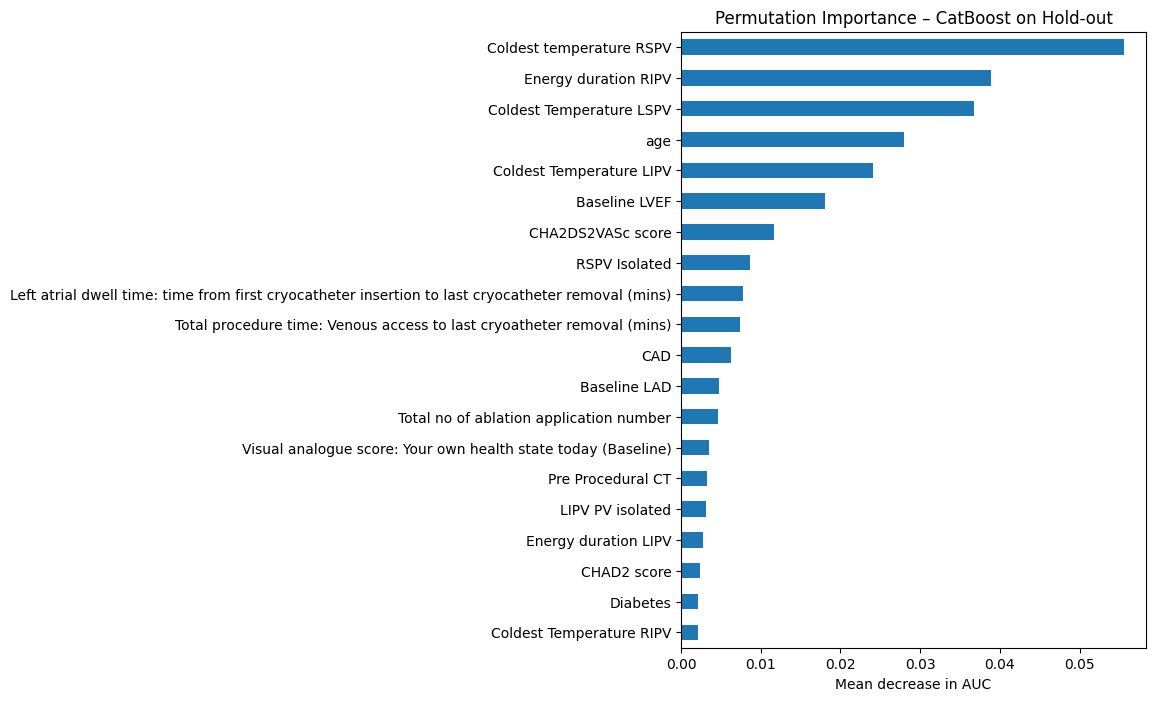

In [44]:
# ╔═╡ Cell 11.2 – Manual permutation importance (CatBoost on hold-out) ─────────╗
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# 1) Extract the trained CatBoost model
cb_entry = models["CatBoost"]
cb_model = (
    cb_entry.named_steps["clf"]
    if hasattr(cb_entry, "named_steps")
    else cb_entry
)

# 2) Prepare hold-out data exactly as CatBoost expects
X_eval_cb = prepare_for_catboost(X_hold.reset_index(drop=True), cat)
y_eval    = y_hold.reset_index(drop=True).values

# 3) Compute baseline AUC on hold-out
y_prob = cb_model.predict_proba(X_eval_cb)[:, 1]
baseline_auc = roc_auc_score(y_eval, y_prob)

# 4) Permutation importance: mean decrease in AUC over n_repeats
n_repeats = 20
rng = np.random.RandomState(RANDOM_STATE)
importances = {}
for feat in X_eval_cb.columns:
    drops = []
    for _ in range(n_repeats):
        X_perm = X_eval_cb.copy()
        X_perm[feat] = rng.permutation(X_perm[feat].values)
        perm_prob = cb_model.predict_proba(X_perm)[:, 1]
        drops.append(baseline_auc - roc_auc_score(y_eval, perm_prob))
    importances[feat] = np.mean(drops)

# 5) Build a Series, select top 20, and plot
imp_series = pd.Series(importances).sort_values(ascending=False).head(20)
plt.figure(figsize=(6, 8))
imp_series[::-1].plot.barh()
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation Importance – CatBoost on Hold-out")
plt.tight_layout()
plt.show()


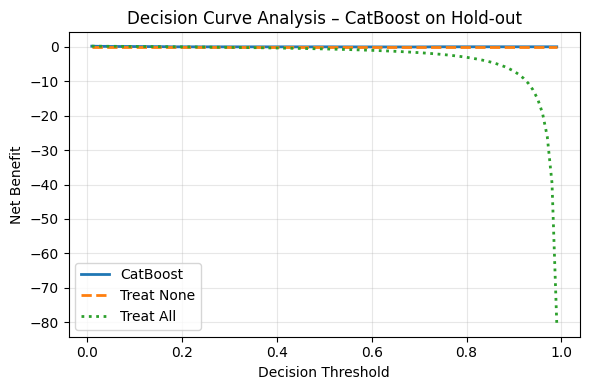

In [45]:
# ╔═╡ Cell 11.3 – Decision Curve Analysis – CatBoost on hold-out ─════════════════╗
import numpy as np
import matplotlib.pyplot as plt

# 1) Extract the trained CatBoost model
cb_entry = models["CatBoost"]
cb_model = cb_entry.named_steps["clf"] if hasattr(cb_entry, "named_steps") else cb_entry

# 2) Prepare hold-out features exactly as CatBoost expects
X_eval_cb = prepare_for_catboost(X_hold.reset_index(drop=True), cat)
y_eval    = y_hold.reset_index(drop=True)

# 3) Predict probabilities for the positive class
probs = cb_model.predict_proba(X_eval_cb)[:, 1]

# 4) Define thresholds (avoiding 0 and 1 to prevent division by zero)
thresholds  = np.linspace(0.01, 0.99, 99)
n_samples   = len(y_eval)
event_rate  = y_eval.mean()

# 5) Compute net benefit for each threshold
net_benefit = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    tp = ((preds == 1) & (y_eval == 1)).sum()
    fp = ((preds == 1) & (y_eval == 0)).sum()
    nb = tp / n_samples - fp / n_samples * (t / (1 - t))
    net_benefit.append(nb)

# 6) Plot decision curves
plt.figure(figsize=(6, 4))
plt.plot(thresholds, net_benefit,           label="CatBoost",   linewidth=2)
plt.plot(thresholds, np.zeros_like(thresholds), "--", label="Treat None", linewidth=2)
plt.plot(
    thresholds,
    event_rate - (1 - event_rate) * (thresholds / (1 - thresholds)),
    ":", label="Treat All", linewidth=2
)
plt.xlabel("Decision Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis – CatBoost on Hold-out")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


CatBoost AUC                      : 0.652
Confusion matrix (thr=0.5):
[[67  2]
 [15  1]]

Classification report:
              precision    recall  f1-score   support

           0      0.817     0.971     0.887        69
           1      0.333     0.062     0.105        16

    accuracy                          0.800        85
   macro avg      0.575     0.517     0.496        85
weighted avg      0.726     0.800     0.740        85



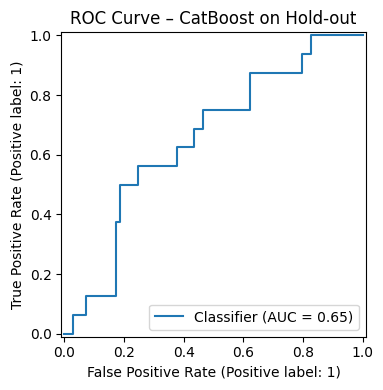

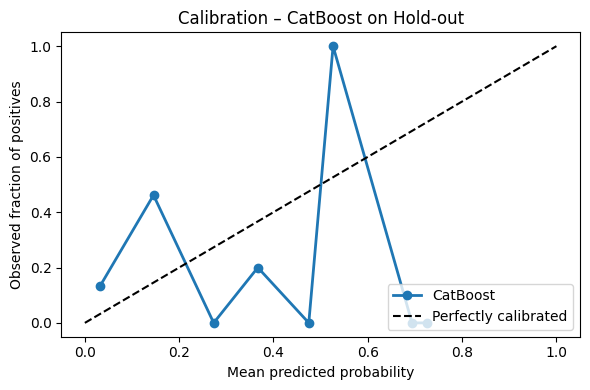

CatBoost Brier score               : 0.1706
Optimal threshold (Youden’s J)    : 0.096

Confusion matrix (optimal thr):
[[52 17]
 [ 7  9]]

Classification report (optimal thr):
              precision    recall  f1-score   support

           0      0.881     0.754     0.812        69
           1      0.346     0.562     0.429        16

    accuracy                          0.718        85
   macro avg      0.614     0.658     0.621        85
weighted avg      0.781     0.718     0.740        85



In [46]:
# ╔═╡ Cell 11.4 – Final evaluation on hold‐out set for CatBoost ─════════════╗
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay,
    roc_curve, brier_score_loss
)
from sklearn.calibration import calibration_curve

# 1) Extract the trained CatBoost model
cb_entry = models["CatBoost"]
clf = cb_entry.named_steps["clf"] if hasattr(cb_entry, "named_steps") else cb_entry

# 2) Prepare hold-out data exactly as CatBoost expects
X_eval = prepare_for_catboost(X_hold.reset_index(drop=True), cat)
y_eval = y_hold.reset_index(drop=True).values

# 3) Predict probabilities and hard labels (threshold=0.5)
y_prob = clf.predict_proba(X_eval)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# 4) Print discrimination & classification metrics
print(f"CatBoost AUC                      : {roc_auc_score(y_eval, y_prob):.3f}")
print("Confusion matrix (thr=0.5):")
print(confusion_matrix(y_eval, y_pred))
print("\nClassification report:")
print(classification_report(y_eval, y_pred, digits=3))

# 5) Plot ROC curve
fig, ax = plt.subplots(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_eval, y_prob, ax=ax)
ax.set_title("ROC Curve – CatBoost on Hold-out")
plt.tight_layout()
plt.show()

# 6) Calibration curve & Brier score
frac_pos, mean_pred = calibration_curve(
    y_eval, y_prob, n_bins=10, strategy="uniform"
)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(mean_pred, frac_pos, marker="o", linewidth=2, label="CatBoost")
ax.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed fraction of positives")
ax.set_title("Calibration – CatBoost on Hold-out")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"CatBoost Brier score               : {brier_score_loss(y_eval, y_prob):.4f}")

# 7) Optimal threshold via Youden’s J
fpr, tpr, thresholds = roc_curve(y_eval, y_prob)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thr = thresholds[best_idx]
print(f"Optimal threshold (Youden’s J)    : {best_thr:.3f}")

# 8) Metrics at optimal threshold
y_opt = (y_prob >= best_thr).astype(int)
print("\nConfusion matrix (optimal thr):")
print(confusion_matrix(y_eval, y_opt))
print("\nClassification report (optimal thr):")
print(classification_report(y_eval, y_opt, digits=3))


In [47]:
# ╔═╡ Cell 11.5 – Calibrate CatBoost on the build set ─════════════════════╗
from sklearn.pipeline    import Pipeline
from sklearn.calibration import CalibratedClassifierCV

# 1) Extract the preprocessing step and raw CatBoost model
cb_entry = models["CatBoost"]
if hasattr(cb_entry, "named_steps"):
    prep_step      = cb_entry.named_steps["prep"]
    base_estimator = cb_entry.named_steps["clf"]
else:
    prep_step      = preprocessor
    base_estimator = cb_entry

# 2) Build a pipeline with Platt‐scaling (sigmoid) calibration
calibrated_cb = Pipeline([
    ("prep", prep_step),
    ("clf",  CalibratedClassifierCV(
                 estimator=base_estimator,
                 method="sigmoid",   # Platt scaling
                 cv=3
             ))
])

# 3) Fit on your build (training) set
calibrated_cb.fit(X_train, y_train)

# 4) Add to your models dict
models["CatBoost_Calibrated"] = calibrated_cb
print("✅ CatBoost_Calibrated added to models")


✅ CatBoost_Calibrated added to models


In [48]:
# ╔═╡ Cell 11.6 – Bootstrap‐ensemble for CatBoost on hold-out ─════════════╗
import numpy as np
from sklearn.utils     import resample
from sklearn.metrics   import roc_auc_score
from catboost          import CatBoostClassifier

# 1) Unpack your preprocessing and base CatBoost model
cb_entry = models["CatBoost"]
if hasattr(cb_entry, "named_steps"):
    prep_step = cb_entry.named_steps["prep"]
    base_cb   = cb_entry.named_steps["clf"]
else:
    prep_step = preprocessor
    base_cb   = cb_entry

# 2) Hold-out data prepared once
X_hold_cb = prepare_for_catboost(X_hold.reset_index(drop=True), cat)
y_hold_arr = y_hold.reset_index(drop=True).values

# 3) Bootstrap settings
n_boot     = 10
boot_preds = np.zeros((len(X_hold_cb), n_boot))

# 4) Bootstrap loop: resample build set, retrain, predict
for i in range(n_boot):
    # a) Resample your build (training) data
    Xb, yb = resample(X_train, y_train, random_state=RANDOM_STATE + i)
    # b) Prepare for CatBoost
    Xb_cb = prepare_for_catboost(Xb, cat)
    # c) Clone base CatBoost params into a fresh model
    cb = CatBoostClassifier(**base_cb.get_params())
    # d) Fit on the bootstrap sample
    cb.fit(
        Xb_cb, yb,
        cat_features=cat_features_idx,
        verbose=False
    )
    # e) Predict probabilities on hold-out
    boot_preds[:, i] = cb.predict_proba(X_hold_cb)[:, 1]

# 5) Aggregate and report AUC
y_mean = boot_preds.mean(axis=1)
print("Bootstrapped CatBoost AUC on hold-out:",
      roc_auc_score(y_hold_arr, y_mean))


Bootstrapped CatBoost AUC on hold-out: 0.6403985507246377


=== Calibrated CatBoost on Hold-out ===
AUC:                        0.611
Confusion matrix (thr=0.5):
[[69  0]
 [16  0]]

Classification report:
              precision    recall  f1-score   support

           0      0.812     1.000     0.896        69
           1      0.000     0.000     0.000        16

    accuracy                          0.812        85
   macro avg      0.406     0.500     0.448        85
weighted avg      0.659     0.812     0.727        85



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


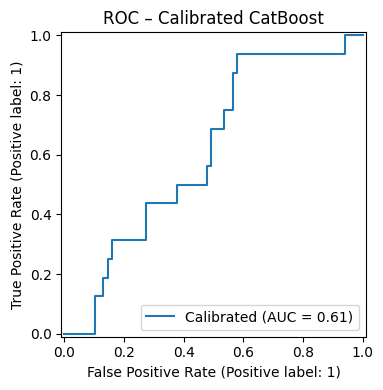

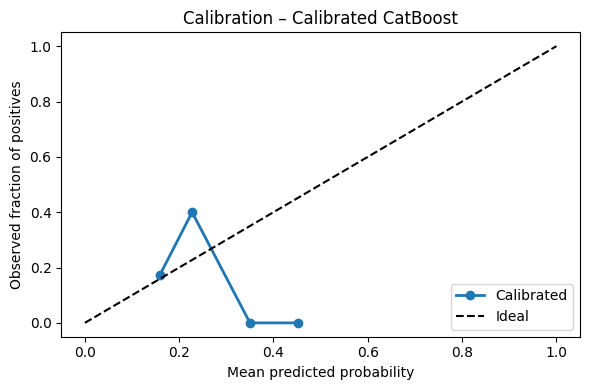

Brier score (Calibrated):   0.1566

=== Bootstrap-ensemble CatBoost on Hold-out ===
AUC:                        0.640
Confusion matrix (thr=0.5):
[[66  3]
 [15  1]]

Classification report:
              precision    recall  f1-score   support

           0      0.815     0.957     0.880        69
           1      0.250     0.062     0.100        16

    accuracy                          0.788        85
   macro avg      0.532     0.510     0.490        85
weighted avg      0.708     0.788     0.733        85



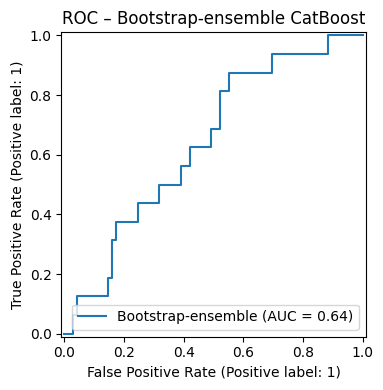

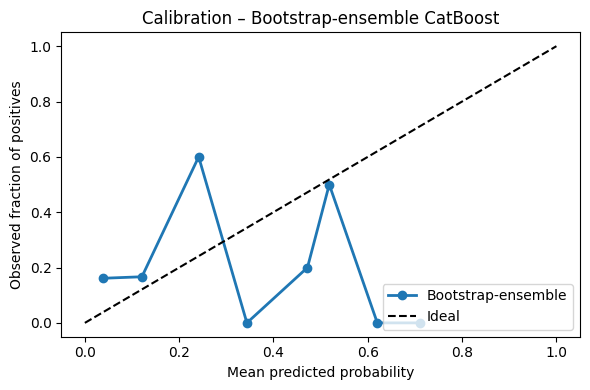

Brier score (Bootstrap-ensemble): 0.1721


In [49]:
# ╔═╡ Cell 11.7 – Compare Calibrated vs. Bootstrap CatBoost on Hold-out ─════╗
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

# Prepare hold-out data (requires that Cell 3 has run)
X_eval = X_hold.reset_index(drop=True)
y_eval = y_hold.reset_index(drop=True)

# 1) Calibrated CatBoost evaluation
cal_cb = models["CatBoost_Calibrated"]
y_cal_proba = cal_cb.predict_proba(X_eval)[:, 1]
y_cal_pred  = (y_cal_proba >= 0.5).astype(int)

print("=== Calibrated CatBoost on Hold-out ===")
print(f"AUC:                        {roc_auc_score(y_eval, y_cal_proba):.3f}")
print("Confusion matrix (thr=0.5):")
print(confusion_matrix(y_eval, y_cal_pred))
print("\nClassification report:")
print(classification_report(y_eval, y_cal_pred, digits=3))

# ROC curve
fig, ax = plt.subplots(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_eval, y_cal_proba, name="Calibrated", ax=ax)
ax.set_title("ROC – Calibrated CatBoost")
plt.tight_layout()
plt.show()

# Calibration curve + Brier score
frac_c, mean_p_c = calibration_curve(y_eval, y_cal_proba, n_bins=10, strategy="uniform")
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(mean_p_c, frac_c, marker="o", linewidth=2, label="Calibrated")
ax.plot([0, 1], [0, 1], "k--", label="Ideal")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed fraction of positives")
ax.set_title("Calibration – Calibrated CatBoost")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Brier score (Calibrated):   {brier_score_loss(y_eval, y_cal_proba):.4f}")
print()

# 2) Bootstrap-ensemble CatBoost evaluation (from Cell 11.6)
#    `boot_preds` must have been created in that cell.
y_boot_mean = boot_preds.mean(axis=1)
y_boot_pred = (y_boot_mean >= 0.5).astype(int)

print("=== Bootstrap-ensemble CatBoost on Hold-out ===")
print(f"AUC:                        {roc_auc_score(y_eval, y_boot_mean):.3f}")
print("Confusion matrix (thr=0.5):")
print(confusion_matrix(y_eval, y_boot_pred))
print("\nClassification report:")
print(classification_report(y_eval, y_boot_pred, digits=3))

# ROC curve
fig, ax = plt.subplots(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_eval, y_boot_mean, name="Bootstrap-ensemble", ax=ax)
ax.set_title("ROC – Bootstrap-ensemble CatBoost")
plt.tight_layout()
plt.show()

# Calibration curve + Brier score
frac_b, mean_p_b = calibration_curve(y_eval, y_boot_mean, n_bins=10, strategy="uniform")
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(mean_p_b, frac_b, marker="o", linewidth=2, label="Bootstrap-ensemble")
ax.plot([0, 1], [0, 1], "k--", label="Ideal")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed fraction of positives")
ax.set_title("Calibration – Bootstrap-ensemble CatBoost")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Brier score (Bootstrap-ensemble): {brier_score_loss(y_eval, y_boot_mean):.4f}")


HistGB AUC: 0.522
Confusion matrix (thr=0.5):
[[59 10]
 [15  1]]

Classification report:
              precision    recall  f1-score   support

           0      0.797     0.855     0.825        69
           1      0.091     0.062     0.074        16

    accuracy                          0.706        85
   macro avg      0.444     0.459     0.450        85
weighted avg      0.664     0.706     0.684        85



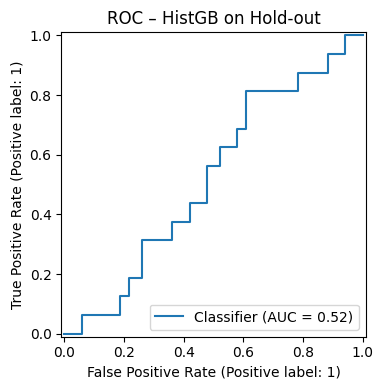

In [50]:
# ╔═╡ Cell 12.1 – HistGB on Hold-out ────────────────────────────────────╗
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay
)

# 1) Unpack your tuned HistGB pipeline
hgb_pipe = models["HistGB"]  # ImbPipeline(prep → SMOTE → HistGB)

# 2) Extract preprocessor and classifier to avoid SMOTE on hold-out
prep = hgb_pipe.named_steps["prep"]
clf  = hgb_pipe.named_steps["clf"]

# 3) Prepare hold-out set
X_eval = X_hold.reset_index(drop=True)
y_eval = y_hold.reset_index(drop=True).values
X_pre  = prep.transform(X_eval)

# 4) Predict & evaluate
y_proba = clf.predict_proba(X_pre)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print(f"HistGB AUC: {roc_auc_score(y_eval, y_proba):.3f}")
print("Confusion matrix (thr=0.5):")
print(confusion_matrix(y_eval, y_pred))
print("\nClassification report:")
print(classification_report(y_eval, y_pred, digits=3))

# 5) ROC curve
fig, ax = plt.subplots(figsize=(6,4))
RocCurveDisplay.from_predictions(y_eval, y_proba, ax=ax)
ax.set_title("ROC – HistGB on Hold-out")
plt.tight_layout()
plt.show()


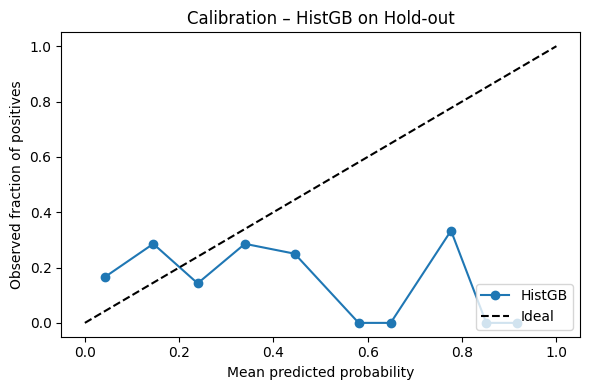

Brier score: 0.2172


In [51]:
# ╔═╡ Cell 12.2 – Calibration Curve + Brier Score for HistGB ─────────────╗
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics      import brier_score_loss

# assumes y_eval, y_proba from Cell 10.1
frac, mean_pred = calibration_curve(
    y_eval, y_proba, n_bins=10, strategy="uniform"
)

plt.figure(figsize=(6,4))
plt.plot(mean_pred, frac, marker="o", label="HistGB")
plt.plot([0,1],[0,1],"k--", label="Ideal")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed fraction of positives")
plt.title("Calibration – HistGB on Hold-out")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Brier score: {brier_score_loss(y_eval, y_proba):.4f}")


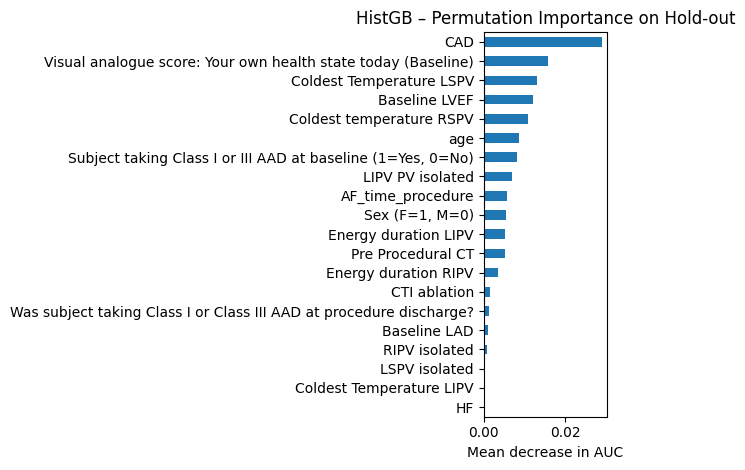

In [52]:
# ╔═╡ Cell 12.3 – Permutation Importance for HistGB ──────────────────╗
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.pipeline   import Pipeline

# 1) Build an evaluation pipeline: preprocess → classifier
eval_pipe = Pipeline([("prep", prep), ("clf", clf)])

# 2) Compute permutation importance on the raw hold‐out features
perm = permutation_importance(
    eval_pipe,
    X_eval,        # raw DataFrame, not the transformed one
    y_eval,
    scoring="roc_auc",
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# 3) Map importances back to the original feature names
perm_ser = pd.Series(perm.importances_mean, index=X_eval.columns).sort_values()

# 4) Plot the top 20 most important raw features
perm_ser.tail(20).plot.barh()
plt.xlabel("Mean decrease in AUC")
plt.title("HistGB – Permutation Importance on Hold-out")
plt.tight_layout()
plt.show()


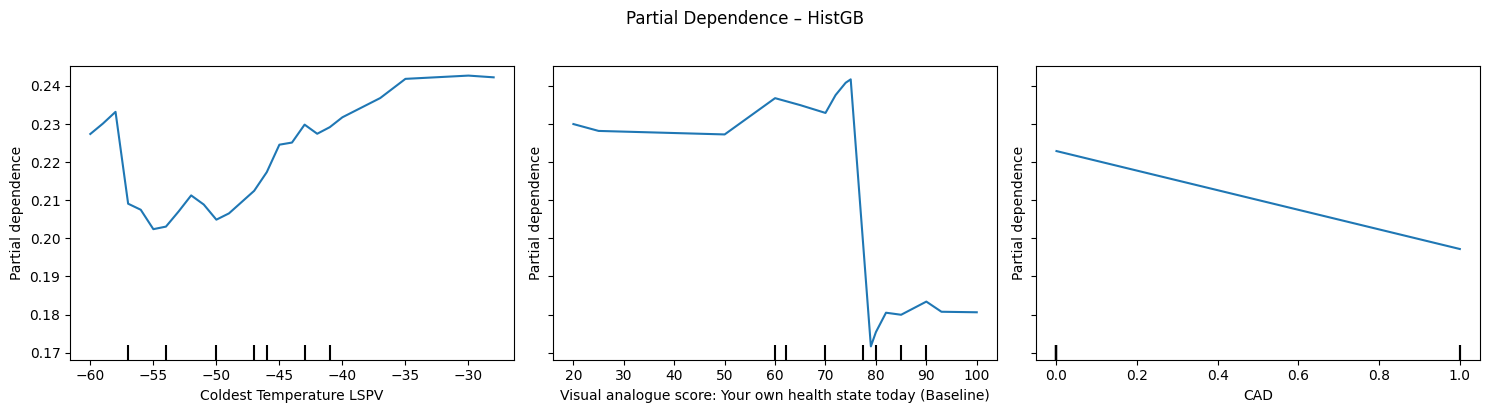

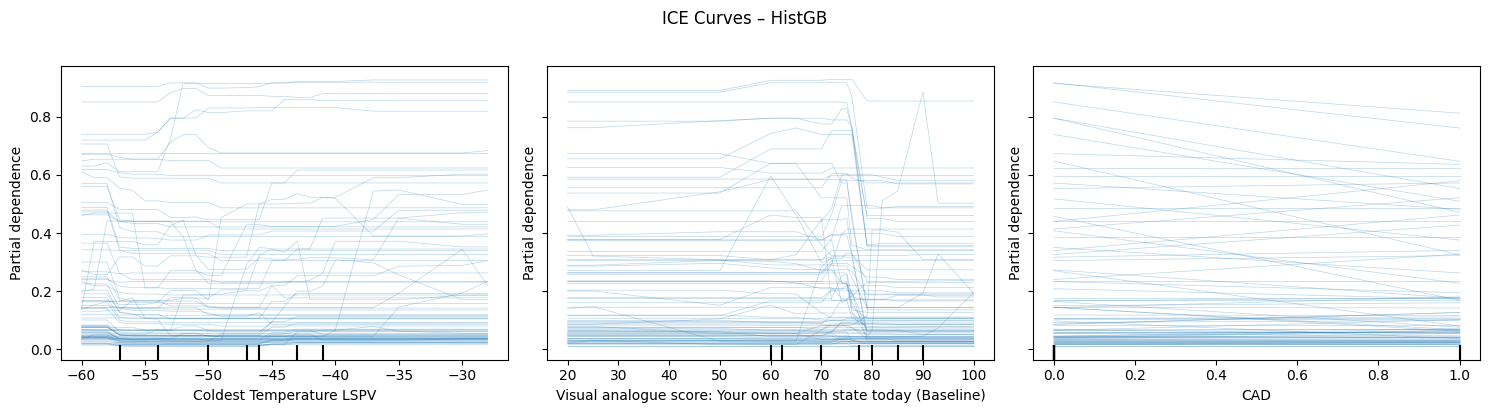

In [53]:
# ╔═╡ Cell 12.4 – Partial Dependence & ICE for top-3 HistGB features ─────────╗
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.pipeline   import Pipeline

# 1) Unpack your tuned HistGB pipeline
hgb_pipe = models["HistGB"]
prep     = hgb_pipe.named_steps["prep"]
clf      = hgb_pipe.named_steps["clf"]

# 2) Prepare hold-out set
X_eval = X_hold.reset_index(drop=True)
y_eval = y_hold.reset_index(drop=True).values

# 3) Build an evaluation pipeline: preprocess → classifier
eval_pipe = Pipeline([("prep", prep), ("clf", clf)])

# 4) Compute permutation importance to rank features
perm = permutation_importance(
    eval_pipe, X_eval, y_eval,
    scoring="roc_auc", n_repeats=10,
    random_state=RANDOM_STATE, n_jobs=-1
)
perm_ser = pd.Series(perm.importances_mean, index=X_eval.columns).sort_values()
top3 = perm_ser.tail(3).index.tolist()

# 5) Partial Dependence (average effect)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
PartialDependenceDisplay.from_estimator(
    eval_pipe,
    X_eval,
    features=top3,
    kind="average",
    ax=axes
)
plt.suptitle("Partial Dependence – HistGB", y=1.02)
plt.tight_layout()
plt.show()

# 6) ICE Curves (individual conditional expectations)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
PartialDependenceDisplay.from_estimator(
    eval_pipe,
    X_eval,
    features=top3,
    kind="individual",
    ax=axes
)
plt.suptitle("ICE Curves – HistGB", y=1.02)
plt.tight_layout()
plt.show()


  0%|          | 0/85 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
<ipython-input-54-3375f94fe6e4>:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


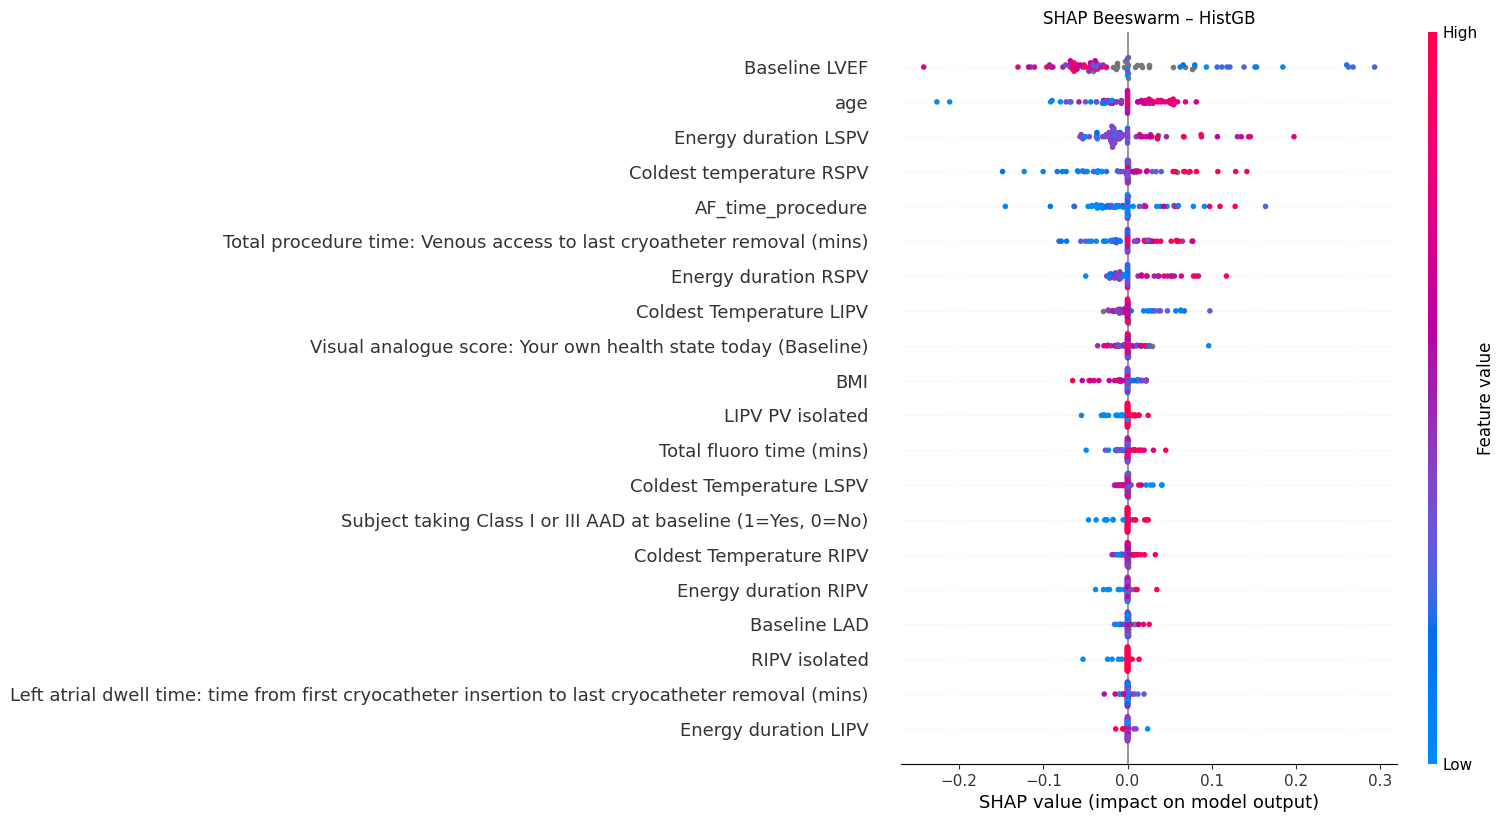

In [54]:
# ╔═╡ Cell 12.5 – SHAP Summary for HistGB (model-agnostic) ─════════════╗
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) Prediction wrapper that handles DF or ndarray
def hgb_proba(data):
    if isinstance(data, np.ndarray):
        df = pd.DataFrame(data, columns=X_eval.columns)
    else:
        df = data.copy()
    return clf.predict_proba(prep.transform(df))[:, 1]

# 2) Background sample for Kernel SHAP
bg = shap.sample(X_eval, 100, random_state=RANDOM_STATE)

# 3) KernelExplainer
explainer = shap.KernelExplainer(hgb_proba, bg)

# 4) Compute SHAP values (reduce nsamples if needed)
shap_vals = explainer.shap_values(X_eval, nsamples=200)

# 5) Beeswarm plot
plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_vals, X_eval,
    feature_names=X_eval.columns.tolist(),
    plot_type="dot", max_display=20,
    show=False
)
plt.title("SHAP Beeswarm – HistGB")
plt.tight_layout()
plt.show()


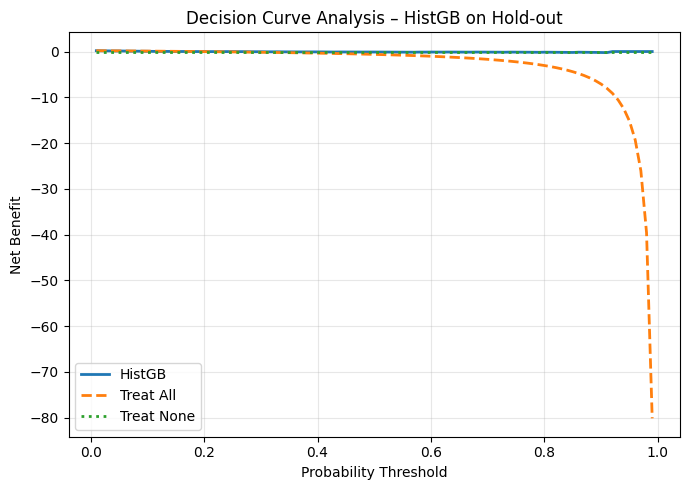

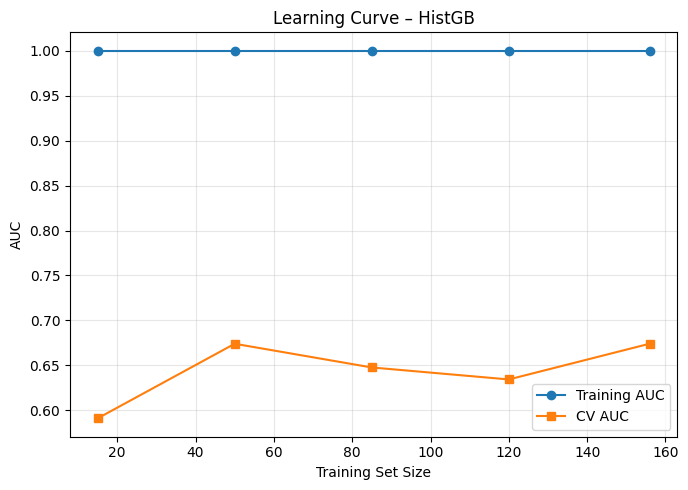

In [55]:
# ╔═╡ Cell 12.6 – Decision‐Curve Analysis + Learning Curves for HistGB ─════╝
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.model_selection import learning_curve, StratifiedKFold

# 0) Unpack your HistGB pipeline (must have been fit already)
hgb_pipe = models["HistGB"]
prep     = hgb_pipe.named_steps["prep"]
clf      = hgb_pipe.named_steps["clf"]

# 1) Decision‐Curve Analysis on hold‐out
eval_pipe = Pipeline([("prep", prep), ("clf", clf)])
X_eval    = X_hold.reset_index(drop=True)
y_eval    = y_hold.reset_index(drop=True).values

probs      = eval_pipe.predict_proba(X_eval)[:, 1]
N          = len(y_eval)
preval     = y_eval.mean()
thresholds = np.linspace(0.01, 0.99, 99)

nb_model = []
nb_all   = []
nb_none  = np.zeros_like(thresholds)

for t in thresholds:
    preds = (probs >= t).astype(int)
    tp = ((preds == 1) & (y_eval == 1)).sum()
    fp = ((preds == 1) & (y_eval == 0)).sum()
    nb_model.append(tp/N - fp/N * (t/(1 - t)))
    nb_all.append(preval - (1 - preval) * (t/(1 - t)))

plt.figure(figsize=(7, 5))
plt.plot(thresholds, nb_model, label="HistGB", linewidth=2)
plt.plot(thresholds, nb_all,   "--", label="Treat All", linewidth=2)
plt.plot(thresholds, nb_none,  ":", label="Treat None", linewidth=2)
plt.xlabel("Probability Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis – HistGB on Hold-out")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Learning Curves on training set
cv         = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
train_sizes, train_scores, test_scores = learning_curve(
    eval_pipe,
    X_train, y_train,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=RANDOM_STATE
)

train_mean = np.mean(train_scores, axis=1)
test_mean  = np.mean(test_scores,  axis=1)

plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_mean, "o-", label="Training AUC")
plt.plot(train_sizes, test_mean,  "s-", label="CV AUC")
plt.xlabel("Training Set Size")
plt.ylabel("AUC")
plt.title("Learning Curve – HistGB")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Calibrated AUC on hold-out: 0.578


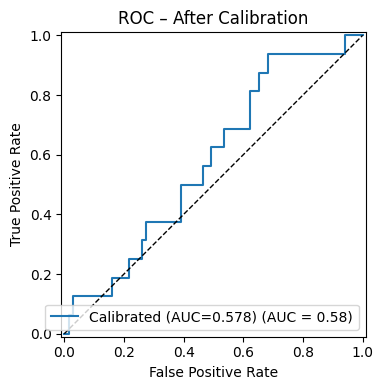

In [56]:
# ╔═╡ Cell 12.7 – ROC Curve After Calibration ───────────────────────────╗
import matplotlib.pyplot as plt
from sklearn.calibration    import CalibratedClassifierCV
from sklearn.metrics       import roc_auc_score, RocCurveDisplay
from sklearn.pipeline      import Pipeline

# 1) Choose your base pipeline (e.g. HistGB or any models["…"])
base_pipe = models["HistGB"]            # or "AdaBoost", "XGBoost", etc.

# 2) Build a calibration wrapper (sigmoid = Platt scaling)
cal_pipe = CalibratedClassifierCV(
    estimator=base_pipe,
    method="sigmoid",
    cv=3
)

# 3) Fit calibrator on your build set (prep + classifier inside)
cal_pipe.fit(X_train, y_train)

# 4) Predict calibrated probabilities on hold-out
y_cal_proba = cal_pipe.predict_proba(X_hold)[:, 1]

# 5) Compute AUC
auc_cal = roc_auc_score(y_hold, y_cal_proba)
print(f"Calibrated AUC on hold-out: {auc_cal:.3f}")

# 6) Plot ROC
fig, ax = plt.subplots(figsize=(6, 4))
RocCurveDisplay.from_predictions(
    y_hold,
    y_cal_proba,
    name=f"Calibrated (AUC={auc_cal:.3f})",
    ax=ax
)
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.title("ROC – After Calibration")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
